# Load the baseline throughput

In [1]:
%load_ext rpy2.ipython

In [3]:
import glob
#**TODO:** move the baseline code to a separate IRIS test app! 
application_files = glob.glob("../sc20/throughput-results/dgemm-*.csv")

import pandas
df = None

for af in application_files:
    names = af.replace(".csv","")
    names = names.replace('../sc20/throughput-results/',"")
    params = names.split("-")
    params.pop(0)
    num_devices = params.pop()
    system = params.pop()
    version = '-'.join([str(x) for x in params])
    runtime = None
    if len(params) == 1:
        runtime = "native"
    elif params[0] == "multigpu":
        runtime = "multigpu"
    else:
        runtime = "iris"
    ops = pandas.read_csv(af,header=None,comment='#')[0].tolist()
    iops = pandas.read_csv(af,header=None,comment='#')[1].tolist()
    flops = pandas.read_csv(af,header=None,comment='#')[2].tolist()

    ndf = pandas.DataFrame({'OPs':ops,'IOPs':iops,'FLOPs':flops,'version':version,'system':system,'runtime':runtime,'num_devices':num_devices})
    if df is None:
        df = ndf
    else:
        df = pandas.merge(df,ndf,how='outer')

throughput = df

In [8]:
%%R -i throughput -h 8.3 -w 11.7 --units in -r 200 -o baseline

outlier_size = 0.5

library('ggplot2')
library('latex2exp')
library('scales')
library('ggsci')
library("ggpattern")
library("dplyr")
library("RColorBrewer")

desat <- function(cols, sat=0.5) {
    X <- diag(c(1, sat, 1)) %*% rgb2hsv(col2rgb(cols))
    hsv(X[1,], X[2,], X[3,])
}

#reorder systems
throughput$System <- throughput$system
throughput$System <- factor(throughput$System, levels = c("Leconte","Equinox","Oswald", "Explorer","Radeon"))

#Create a custom color scale
#myColors <- brewer.pal(n = 5, name = "Dark2")
myColors <- viridis_pal(option = "plasma")(5)
names(myColors) <- levels(factor(levels(throughput$System)))
print(myColors)
colScale <- scale_colour_manual(name="System",values=myColors)
colFill <- scale_fill_manual(name="System",values=myColors)

#reorder according to base implementation.
throughput$version <- recode(throughput$version, "iris-cuda" = "CUDA", "iris-hip" = "HIP", "iris-opencl" = "OpenCL")
throughput$version <- factor(throughput$version, levels = c("CUDA","HIP","OpenCL"))

throughput$num_devices <- as.integer(throughput$num_devices)

#drop OpenCL
throughput %>% filter(version != "OpenCL") %>% {. ->> throughput}

library(dplyr)

throughput%>%
group_by(System,  version, num_devices)%>% 
summarise(Mean=mean(FLOPs), Max=max(FLOPs), Min=min(FLOPs), Median=median(FLOPs), Std=sd(FLOPs)) %>%
{. ->> tp_sum }

p0 <- ggplot(tp_sum, aes(x=num_devices, y=Median, group=interaction(System,version), colour=System, fill=System)) + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 6)) + expand_limits(y = 0) + labs(colour = "Version", fill="System", x="Number of Concurrent Device Enqueues", y=TeX("GFLOPs (Double Precision)"))
p0 <- p0 + geom_ribbon(aes(ymin = Median-Std, ymax = Median+Std),alpha=0.3, linetype = 0) + geom_line(aes(y = Median), alpha=1.0, size=0.75)
baseline <- p0 + colFill + colScale + scale_x_continuous(breaks=min(tp_sum$num_devices):max(tp_sum$num_devices))

#print(p0)

#ggsave(filename="throughput-native.pdf",path="./iris-and-dagger-paper/figures",height=8.3,width=11.7,units="in",dpi="retina")


    Equinox    Explorer     Leconte      Oswald      Radeon 
"#0D0887FF" "#7E03A8FF" "#CC4678FF" "#F89441FF" "#F0F921FF" 
`summarise()` has grouped output by 'System', 'version'. You can override using the `.groups` argument.


# Linear 10 Benchmark

## Generate with DAGGER and view

**Note:** The `ijk` kernel is the name of the major compute component for DGEMM.

In [ ]:
! ./dagger_generator.py --kernels="bigk" --duplicates="0" --buffers-per-kernel="bigk:w r r" --kernel-dimensions="bigk:2" --kernel-split='100' --depth=10 --num-tasks=10 --min-width=1 --max-width=1
! mv dag.png ./iris-and-dagger-paper/figures/linear10.png
from IPython.display import Image
Image("./iris-and-dagger-paper/figures/linear10.png", width=600, height=600)

TODO: ensure all kernels dimensions are provided---no kernel is missed
TODO: Implement kernel_dimensions
TODO: could handle multiple dimensions of execution here
TODO: support multiple targets--hint all but the h2d and d2h memory transfers should be transfer target (control-dependency) while all actual kernels should use the data-dependency
done


## Linear 10 running on Leconte (6x Tesla V100 GPUs) Over all IRIS scheduling policies

*Hint: see `run-policy-evaluation.sh`*

['Tesla V100-SXM2-16GB #0']
['Tesla V100-SXM2-16GB #4', 'Tesla V100-SXM2-16GB #5', 'Tesla V100-SXM2-16GB #0', 'Tesla V100-SXM2-16GB #2', 'Tesla V100-SXM2-16GB #3', 'Tesla V100-SXM2-16GB #1']
['Tesla V100-SXM2-16GB #4', 'Tesla V100-SXM2-16GB #5', 'Tesla V100-SXM2-16GB #0', 'Tesla V100-SXM2-16GB #2', 'Tesla V100-SXM2-16GB #3', 'Tesla V100-SXM2-16GB #1']
['Tesla V100-SXM2-16GB #4', 'Tesla V100-SXM2-16GB #5', 'Tesla V100-SXM2-16GB #0', 'Tesla V100-SXM2-16GB #2', 'Tesla V100-SXM2-16GB #3', 'Tesla V100-SXM2-16GB #1']
['Tesla V100-SXM2-16GB #0']


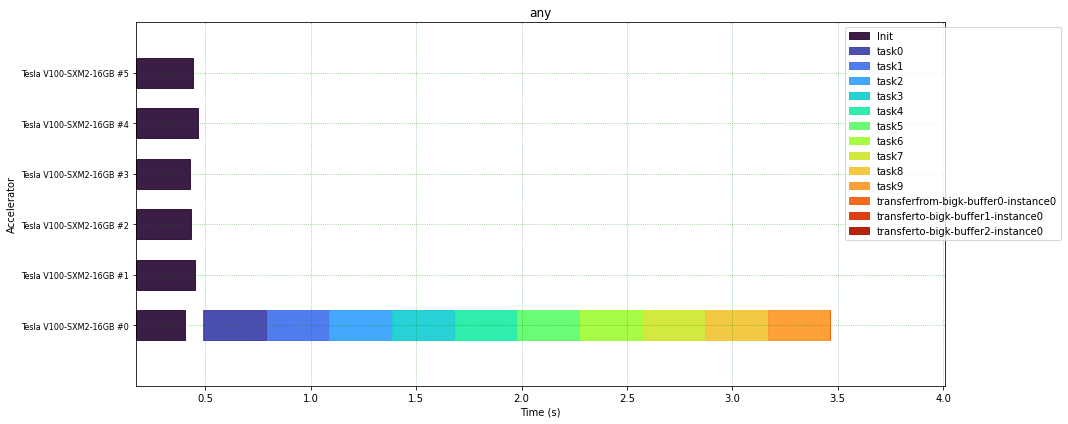

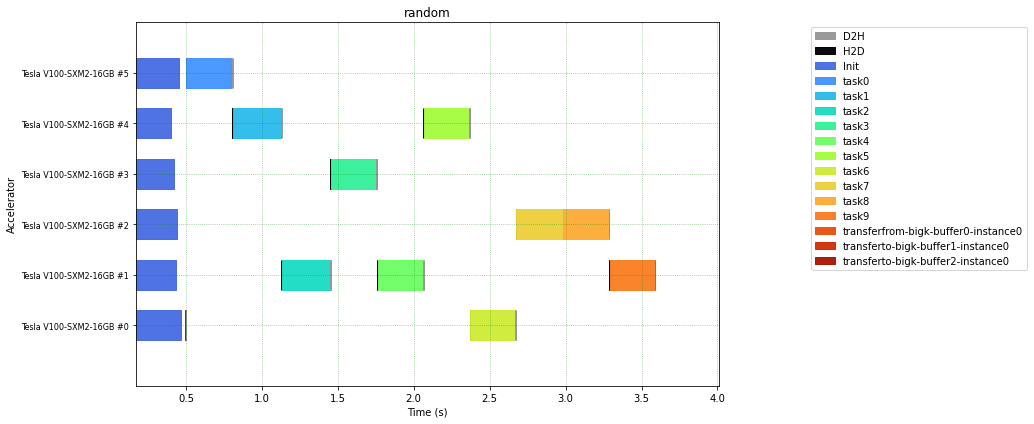

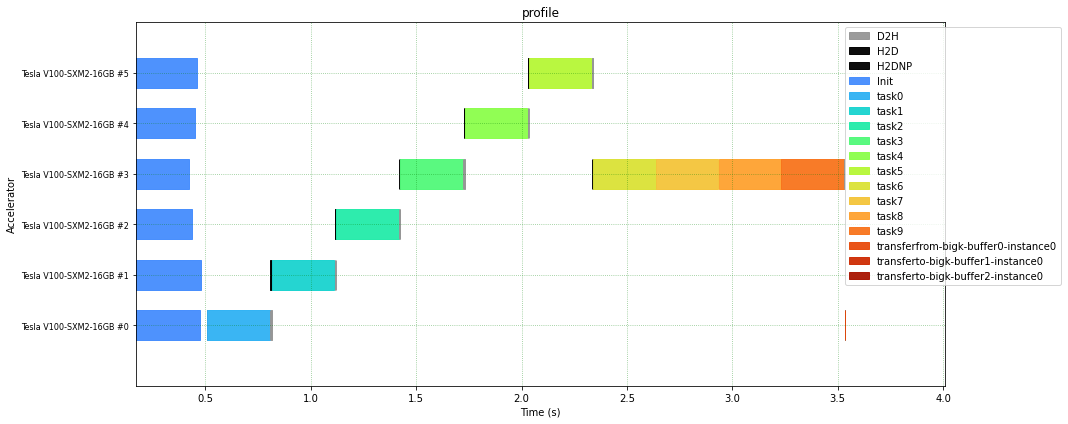

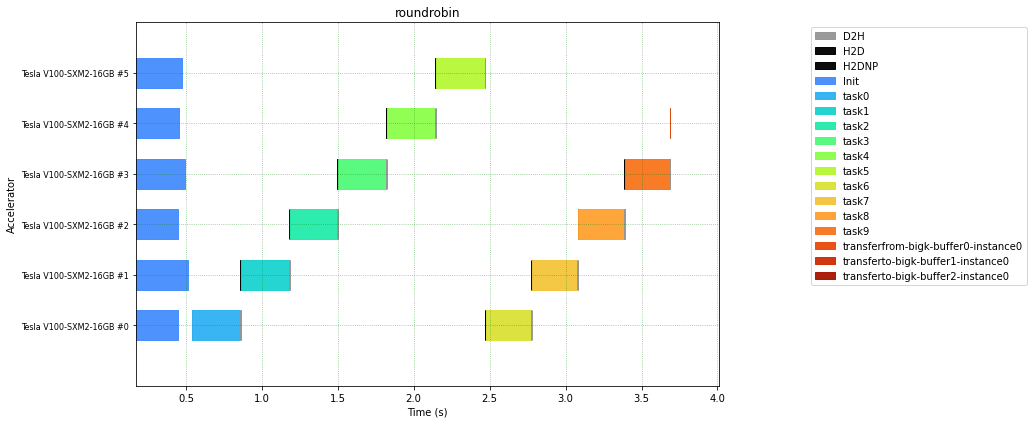

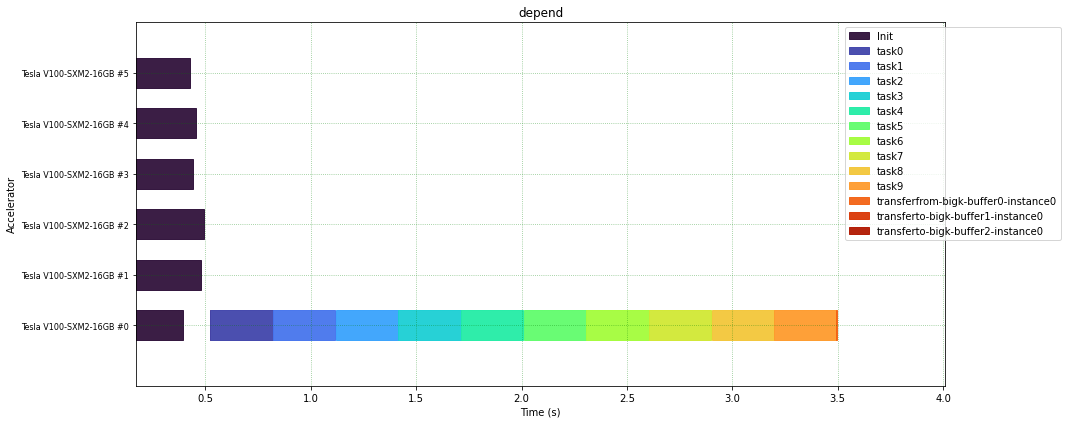

In [61]:
#no initialization reported:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' > filtered.csv
#no H2D or D2H reported:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#all filtering:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#no filtering:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv > filtered.csv
import os
import sys
import importlib
import pandas as pandas
import gantt.gantt as gantt
importlib.reload(gantt)
g = gantt.Gantt()

#get the minimum and maximum time values---to show a consistent time range in the plot
mint = sys.float_info.max
maxt = sys.float_info.min
for r,d,files in os.walk('./linear-10-results'):
    for f in files:
        source_file = r+'/'+f
        x = pandas.read_csv(source_file)
        
        #drop entries without
        x = x.dropna()
        print(list(set(x['acclname'])))
        #drop Init
        #x = x[x.taskname != 'Init']
        mint = min(mint,min(x['start']))
        maxt = max(maxt,max(x['end']))

window_buffer = (maxt-mint)/10
time_range = [mint-window_buffer, maxt+window_buffer]

#generate the plots
for r,d,files in os.walk('./linear-10-results'):
    for f in files:
        source_file = r+'/'+f
        g.saveGanttChart(source_file,file=f.replace('.csv','.pdf'),drop=[],title=f.replace('linear-10-','').replace('.csv',''),time_range=time_range,outline=False)
        
#from gantt import gantt as gantt
#g = gantt.Gantt()
#from glob import glob

#fp = glob('./filtered.csv')
#g.showGanttChart(fp.pop(),"Linear10 on Leconte (CUDA) Policy: Round-Robin")
#g.saveGanttChart(glob('./filtered.csv').pop(),file="filtered-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")

#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' > filtered.csv
#g.saveGanttChart(glob('./filtered.csv').pop(),file="rawish-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")

# Without Memory Ownership Fix:

['Tesla V100-SXM2-16GB #0']
['Tesla V100-SXM2-16GB #4', 'Tesla V100-SXM2-16GB #5', 'Tesla V100-SXM2-16GB #0', 'Tesla V100-SXM2-16GB #2', 'Tesla V100-SXM2-16GB #3']
['Tesla V100-SXM2-16GB #4', 'Tesla V100-SXM2-16GB #5', 'Tesla V100-SXM2-16GB #0', 'Tesla V100-SXM2-16GB #2', 'Tesla V100-SXM2-16GB #3', 'Tesla V100-SXM2-16GB #1']
['Tesla V100-SXM2-16GB #4', 'Tesla V100-SXM2-16GB #5', 'Tesla V100-SXM2-16GB #0', 'Tesla V100-SXM2-16GB #2', 'Tesla V100-SXM2-16GB #3', 'Tesla V100-SXM2-16GB #1']
['Tesla V100-SXM2-16GB #0']


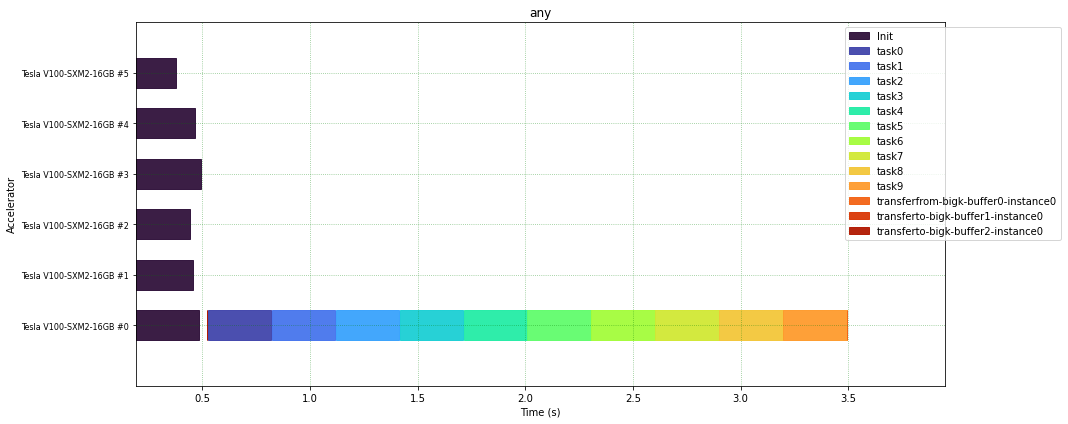

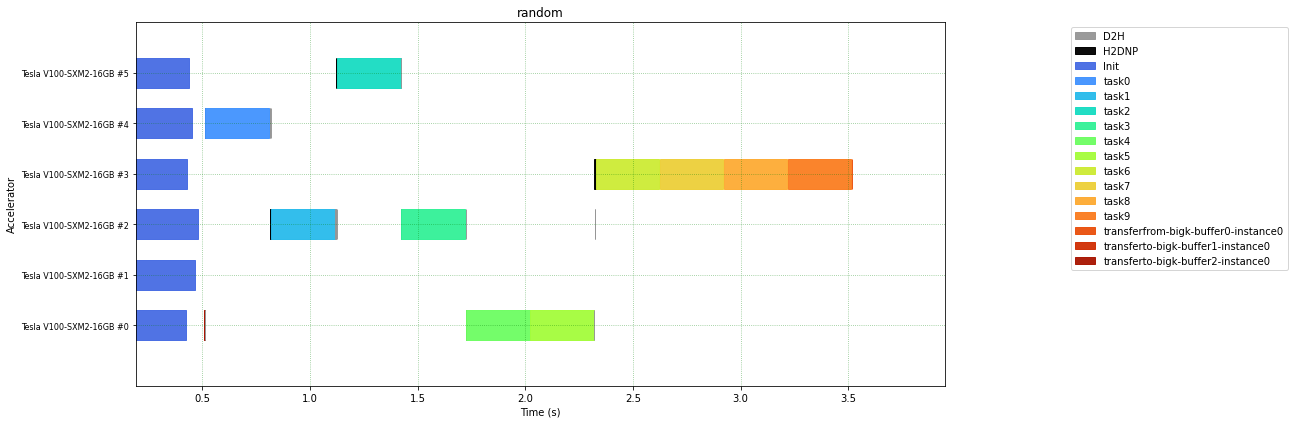

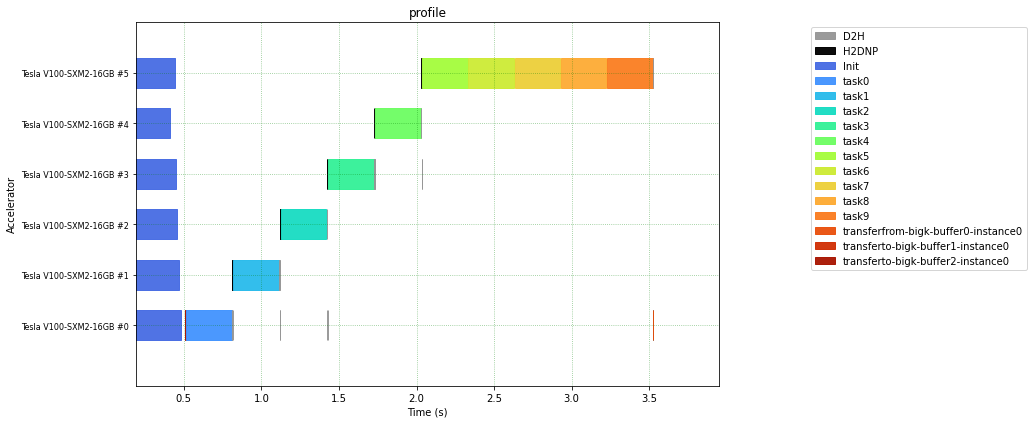

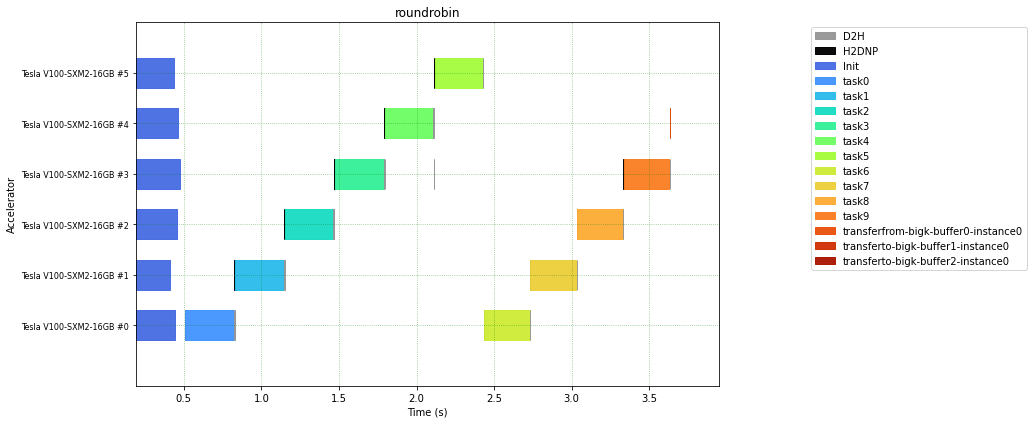

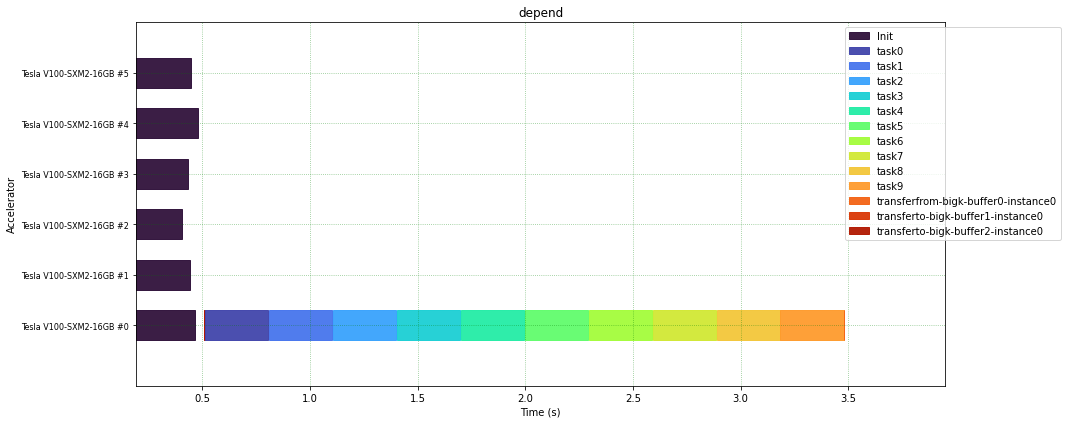

In [60]:
#no initialization reported:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' > filtered.csv
#no H2D or D2H reported:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#all filtering:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#no filtering:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv > filtered.csv
import os
import sys
import importlib
import pandas as pandas
import gantt.gantt as gantt
importlib.reload(gantt)
g = gantt.Gantt()

#get the minimum and maximum time values---to show a consistent time range in the plot
mint = sys.float_info.max
maxt = sys.float_info.min
for r,d,files in os.walk('./linear-10-results'):
    for f in files:
        source_file = r+'/'+f
        x = pandas.read_csv(source_file)
        
        #drop entries without
        x = x.dropna()
        print(list(set(x['acclname'])))
        #drop Init
        #x = x[x.taskname != 'Init']
        mint = min(mint,min(x['start']))
        maxt = max(maxt,max(x['end']))

window_buffer = (maxt-mint)/10
time_range = [mint-window_buffer, maxt+window_buffer]

#generate the plots
for r,d,files in os.walk('./linear-10-results'):
    for f in files:
        source_file = r+'/'+f
        g.saveGanttChart(source_file,file=f.replace('.csv','.pdf'),drop=[],title=f.replace('linear-10-','').replace('.csv',''),time_range=time_range,outline=False)
        
#from gantt import gantt as gantt
#g = gantt.Gantt()
#from glob import glob

#fp = glob('./filtered.csv')
#g.showGanttChart(fp.pop(),"Linear10 on Leconte (CUDA) Policy: Round-Robin")
#g.saveGanttChart(glob('./filtered.csv').pop(),file="filtered-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")

#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' > filtered.csv
#g.saveGanttChart(glob('./filtered.csv').pop(),file="rawish-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")

# Correction on IRIS DATA (Pending) Policy

['Tesla V100-SXM2-16GB #0', 'Tesla V100-SXM2-16GB #1']
['Tesla V100-SXM2-16GB #4', 'Tesla V100-SXM2-16GB #5', 'Tesla V100-SXM2-16GB #0', 'Tesla V100-SXM2-16GB #2', 'Tesla V100-SXM2-16GB #3', 'Tesla V100-SXM2-16GB #1']
['Tesla V100-SXM2-16GB #4', 'Tesla V100-SXM2-16GB #5', 'Tesla V100-SXM2-16GB #0', 'Tesla V100-SXM2-16GB #2', 'Tesla V100-SXM2-16GB #3', 'Tesla V100-SXM2-16GB #1']
['Tesla V100-SXM2-16GB #4', 'Tesla V100-SXM2-16GB #5', 'Tesla V100-SXM2-16GB #0', 'Tesla V100-SXM2-16GB #2', 'Tesla V100-SXM2-16GB #3', 'Tesla V100-SXM2-16GB #1']
['Tesla V100-SXM2-16GB #0', 'Tesla V100-SXM2-16GB #1']


TypeError: '<' not supported between instances of 'str' and 'float'

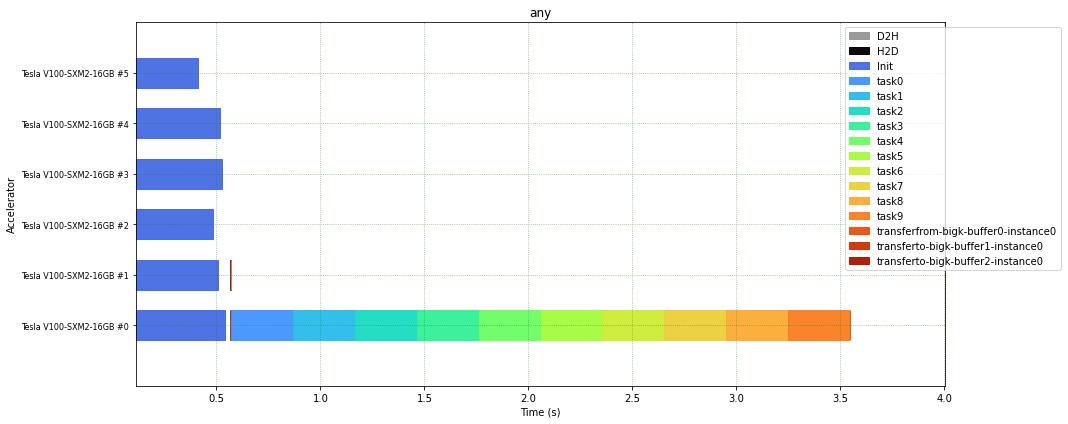

In [63]:
#no initialization reported:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' > filtered.csv
#no H2D or D2H reported:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#all filtering:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#no filtering:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv > filtered.csv
import os
import sys
import importlib
import pandas as pandas
import gantt.gantt as gantt
importlib.reload(gantt)
g = gantt.Gantt()

#get the minimum and maximum time values---to show a consistent time range in the plot
mint = sys.float_info.max
maxt = sys.float_info.min
for r,d,files in os.walk('./linear-10-results'):
    for f in files:
        source_file = r+'/'+f
        x = pandas.read_csv(source_file)
        
        #drop entries without
        x = x.dropna()
        print(list(set(x['acclname'])))
        #drop Init
        #x = x[x.taskname != 'Init']
        mint = min(mint,min(x['start']))
        maxt = max(maxt,max(x['end']))

window_buffer = (maxt-mint)/10
time_range = [mint-window_buffer, maxt+window_buffer]

#generate the plots
for r,d,files in os.walk('./linear-10-results'):
    for f in files:
        source_file = r+'/'+f
        g.saveGanttChart(source_file,file=f.replace('.csv','.pdf'),drop=[],title=f.replace('linear-10-','').replace('.csv',''),time_range=time_range,outline=False)
        
#from gantt import gantt as gantt
#g = gantt.Gantt()
#from glob import glob

#fp = glob('./filtered.csv')
#g.showGanttChart(fp.pop(),"Linear10 on Leconte (CUDA) Policy: Round-Robin")
#g.saveGanttChart(glob('./filtered.csv').pop(),file="filtered-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")

#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' > filtered.csv
#g.saveGanttChart(glob('./filtered.csv').pop(),file="rawish-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")

## Linear 10 running on Explorer (Epyc 7702 with two AMD MI60 Instinct GPUs) Over all IRIS scheduling policies

*Hint: see `run-policy-evaluation.sh`*

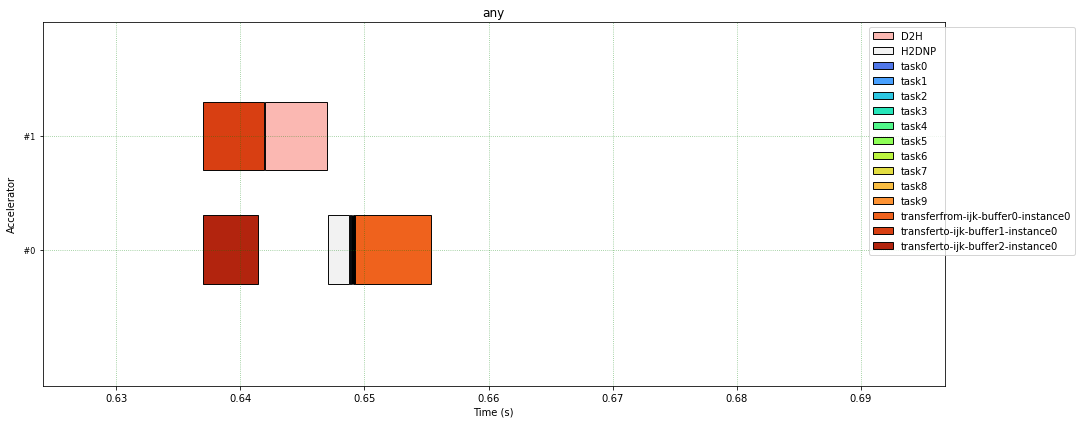

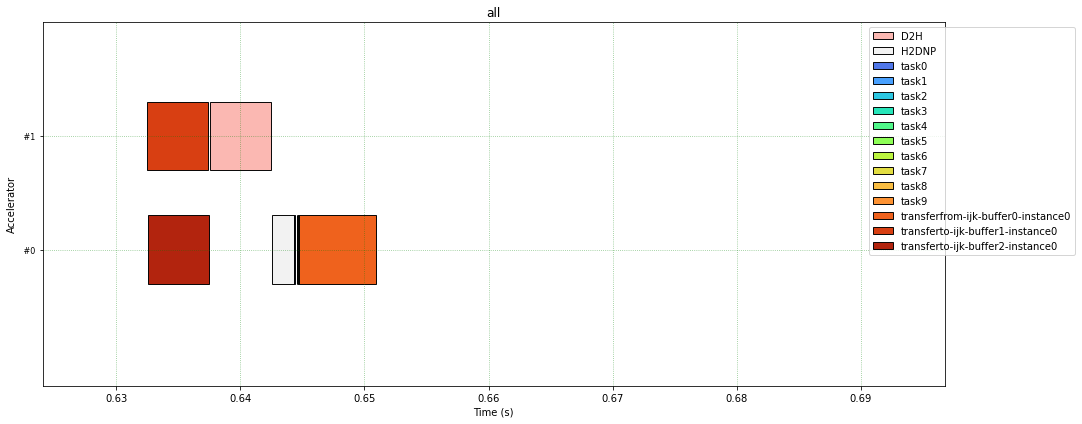

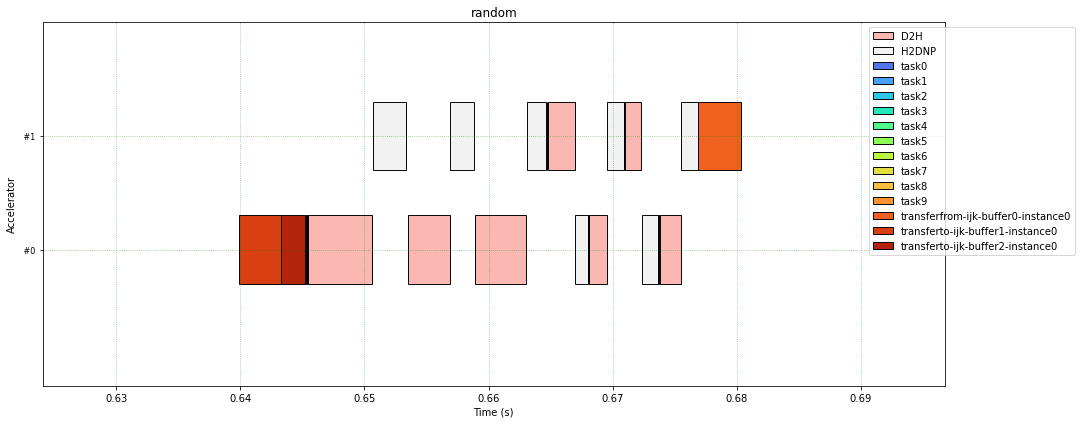

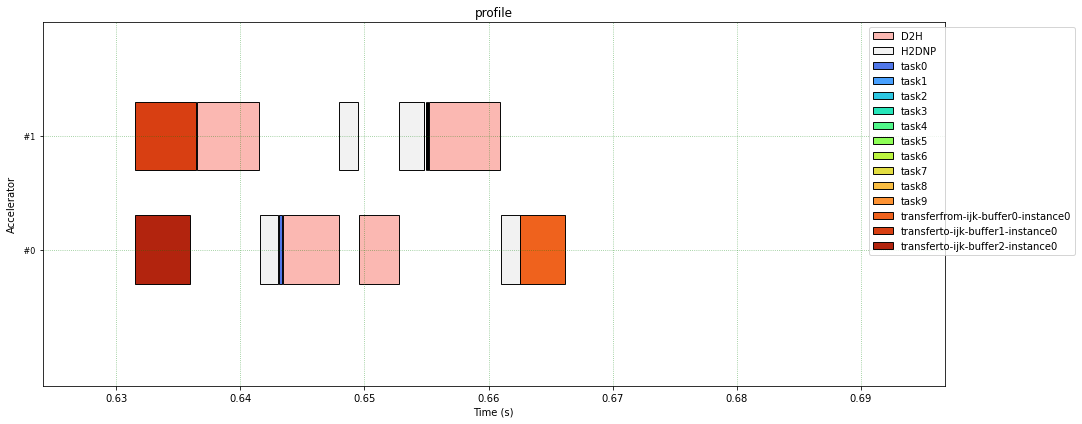

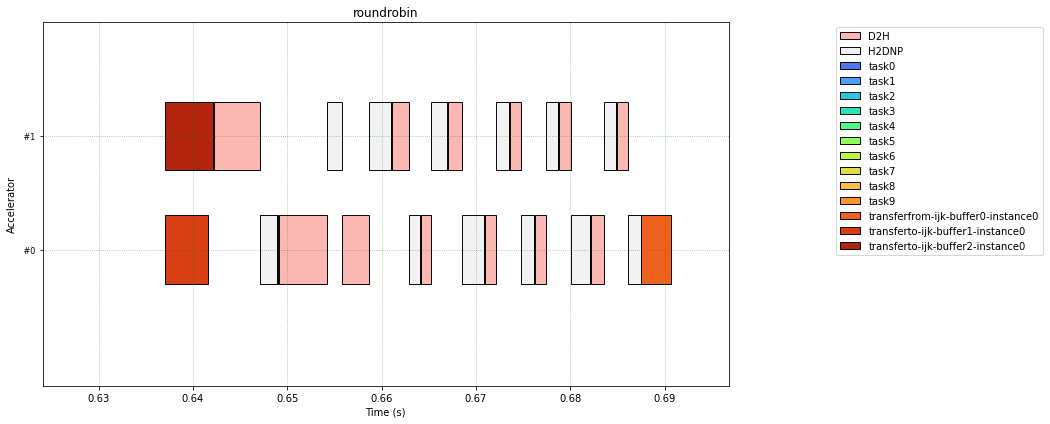

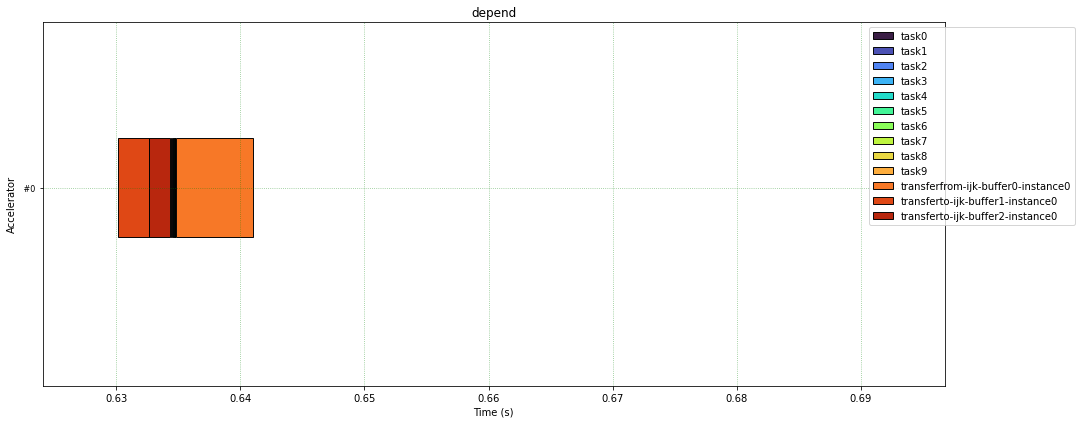

In [39]:
#no initialization reported:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' > filtered.csv
#no H2D or D2H reported:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#all filtering:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#no filtering:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv > filtered.csv
import os
import sys
import importlib
import pandas as pandas
import gantt.gantt as gantt
importlib.reload(gantt)
g = gantt.Gantt()

#get the minimum and maximum time values---to show a consistent time range in the plot
mint = sys.float_info.max
maxt = sys.float_info.min
for r,d,files in os.walk('./linear-10-results'):
    for f in files:
        source_file = r+'/'+f
        x = pandas.read_csv(source_file)
        #drop Init
        x = x[x.taskname != 'Init']
        mint = min(mint,min(x['start']))
        maxt = max(maxt,max(x['end']))

window_buffer = (maxt-mint)/10
time_range = [mint-window_buffer, maxt+window_buffer]

#generate the plots
for r,d,files in os.walk('./linear-10-results'):
    for f in files:
        source_file = r+'/'+f
        g.saveGanttChart(source_file,file=f.replace('.csv','.pdf'),drop=['Init'],title=f.replace('linear-10-','').replace('.csv',''),time_range=time_range)
        
#from gantt import gantt as gantt
#g = gantt.Gantt()
#from glob import glob

#fp = glob('./filtered.csv')
#g.showGanttChart(fp.pop(),"Linear10 on Leconte (CUDA) Policy: Round-Robin")
#g.saveGanttChart(glob('./filtered.csv').pop(),file="filtered-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")

#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' > filtered.csv
#g.saveGanttChart(glob('./filtered.csv').pop(),file="rawish-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")

# Diamond 10 Benchmark

## Generate with DAGGER and view

**Note:** The `ijk` kernel is the name of the major compute component for DGEMM.

TODO: ensure all kernels dimensions are provided---no kernel is missed
TODO: Implement kernel_dimensions
Traceback (most recent call last):
  File "./dagger_generator.py", line 446, in <module>
    task_per_level, level_per_task = gen_task_nodes(_depth,_num_tasks,_min_width,_max_width)
  File "./dagger_generator.py", line 129, in gen_task_nodes
    num_list = random_list(depth+2,total_num,width_min,width_max)
  File "./dagger_generator.py", line 112, in random_list
    assert width_min <= total_num , "--num-tasks must be greater than or equal to the --min-width"
AssertionError: --num-tasks must be greater than or equal to the --min-width


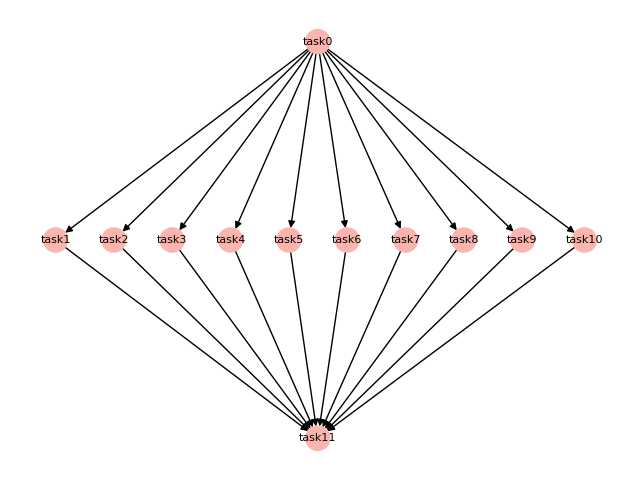

In [43]:
! ./dagger_generator.py --kernels="ijk" --concurrent-kernels="ijk:10" --buffers-per-kernel="ijk:w r r" --kernel-dimensions="ijk:2" --kernel-split='100' --depth=3 --num-tasks=1 --min-width=10 --max-width=10 --sandwich

from IPython.display import Image
Image("./dag.png", width=600, height=600)

## Diamond 10 running on Explorer (Epyc 7702 with two AMD MI60 Instinct GPUs) Over all IRIS scheduling policies

*Hint: see `run-policy-evaluation.sh`*

In [44]:
import os
import sys
import importlib
import pandas as pandas
import gantt.gantt as gantt
importlib.reload(gantt)
g = gantt.Gantt()

#get the minimum and maximum time values---to show a consistent time range in the plot
mint = sys.float_info.max
maxt = sys.float_info.min
for r,d,files in os.walk('./diamond-10-results'):
    for f in files:
        source_file = r+'/'+f
        x = pandas.read_csv(source_file)
        #drop Init
        x = x[x.taskname != 'Init']
        mint = min(mint,min(x['start']))
        maxt = max(maxt,max(x['end']))

window_buffer = (maxt-mint)/10
time_range = [mint-window_buffer, maxt+window_buffer]

#generate the plots
for r,d,files in os.walk('./diamond-10-results'):
    for f in files:
        source_file = r+'/'+f
        #g.saveGanttChart(source_file,file=f.replace('.csv','.pdf'),drop=['Init'],title=f.replace('diamond-10-','').replace('.csv',''),time_range=time_range)
        g.saveGanttChart(source_file,file=f.replace('.csv','.pdf'),drop=['Init','D2H','H2DNP','transferfrom-ijk-buffer0-instance0','transferto-ijk-buffer1-instance0','transferto-ijk-buffer2-instance0'],title=f.replace('diamond-10-','').replace('.csv',''),zoom=True,outline=False)#time_range=time_range)
        
#from gantt import gantt as gantt
#g = gantt.Gantt()
#from glob import glob

#fp = glob('./filtered.csv')
#g.showGanttChart(fp.pop(),"Linear10 on Leconte (CUDA) Policy: Round-Robin")
#g.saveGanttChart(glob('./filtered.csv').pop(),file="filtered-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")

#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' > filtered.csv
#g.saveGanttChart(glob('./filtered.csv').pop(),file="rawish-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")

## Leconte

In [73]:
# results are generated on each of our systems by calling the top level script:
#./run-dagger-runner-on-all-platorms.sh

#this perfoms the ssh connection to each of the systems and calls the respective ./dagger-runner-scripts/run-dagger-runner-{*}.sh, where {*} is cuda, opencl and hip.
#The desired backend is selected according to our knowledge of the systems.
#e.g.
#    ./dagger-runner-scripts/run-dagger-runner-cuda.sh
#Results are saved into the dagger-results subdirectory with:
#    make save-results

#Timing data of each task can be collected by enabling `BRISBANE_PROFILE=1` before each run of dagger_runner, e.g.:
#  BRISBANE_PROFILE=1 ./dagger_runner --kernels="ijk" --kernel-split='100' --depth=10 --num-tasks=9 --min-width=1 --max-width=1 --concurrent-kernels="ijk:1" --buffers-per-kernel="ijk:w r r" --kernel-dimensions="ijk:2" --size=16384 --repeats=1 --logfile=throughput-log-linear-10-$MACHINE.csv --scheduler="round-robin"
#make save-results

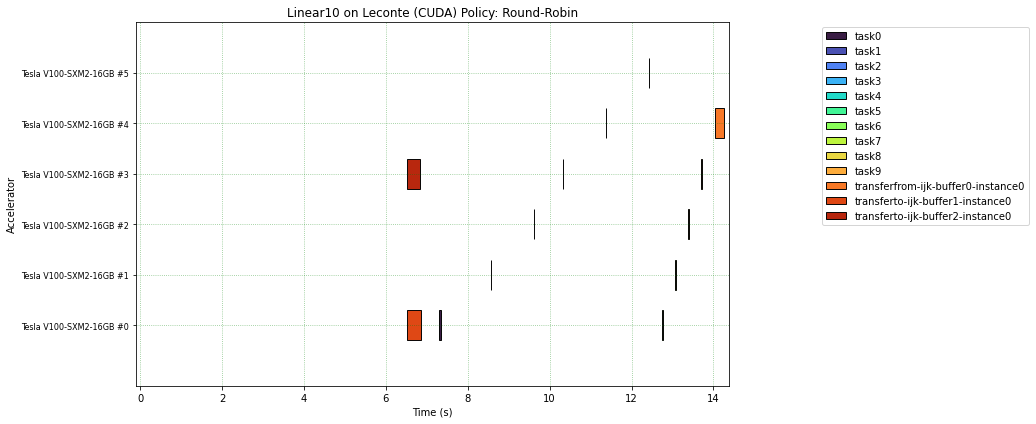

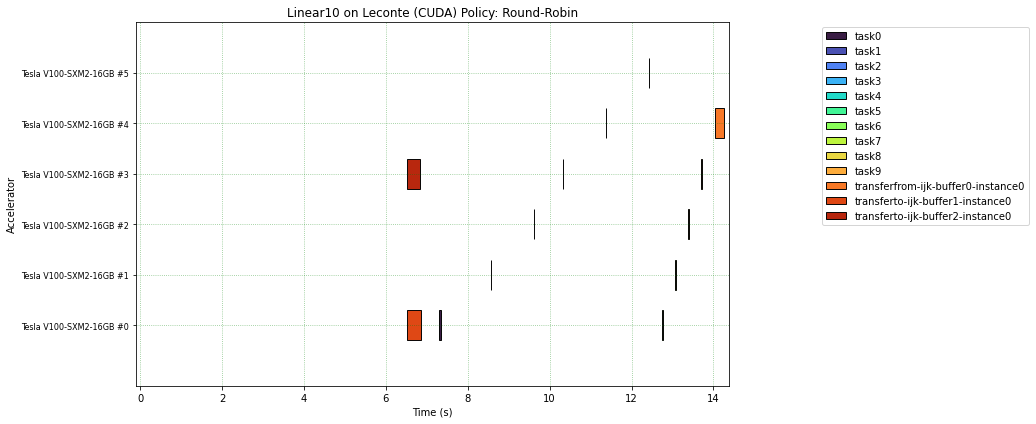

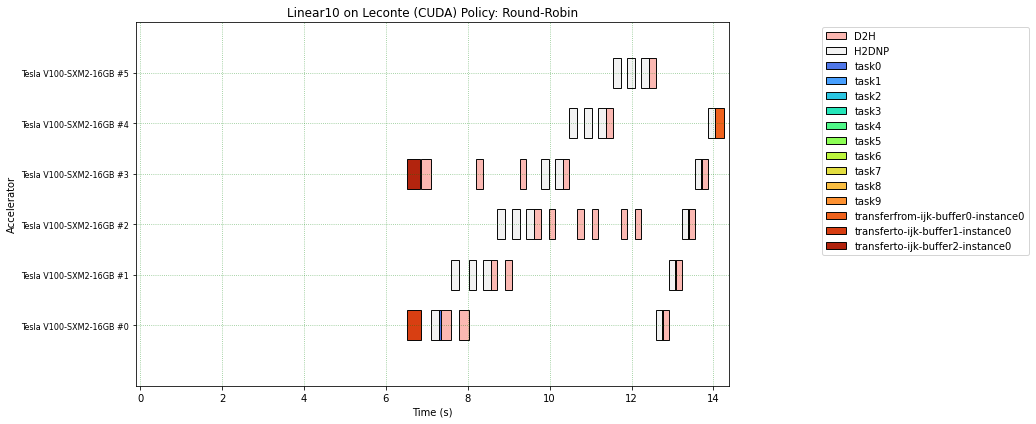

In [5]:
#no initialization reported:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' > filtered.csv
#no H2D or D2H reported:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#all filtering:
! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#no filtering:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.showGanttChart(fp.pop(),"Linear10 on Leconte (CUDA) Policy: Round-Robin")
g.saveGanttChart(glob('./filtered.csv').pop(),file="filtered-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")

! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' > filtered.csv
g.saveGanttChart(glob('./filtered.csv').pop(),file="rawish-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")

Without Initialization:

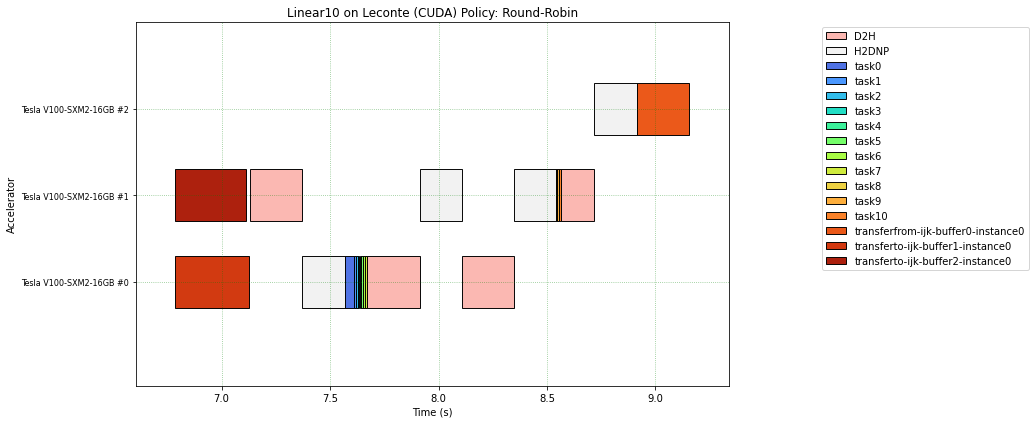

In [214]:
# and without the Init times
#no initialization reported:
! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' > filtered.csv
#no H2D or D2H reported:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#no filtering:
# cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
fname = fp.pop()
#g.showGanttChart(fp.pop(),"Linear10 on Equinox (CUDA)",time_range=(0.624,0.632))
#g.showGanttChart(fname,"Linear10 on Leconte (CUDA) Policy: Round-Robin",zoom=True)
g.saveGanttChart(fname,file="current_roundrobin.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin",zoom=True)

Without Initialization and Memory Transfers:

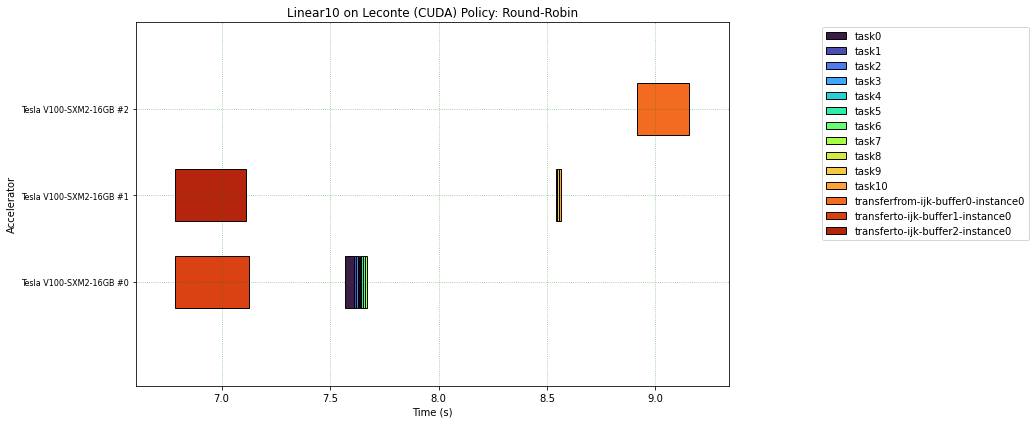

In [215]:
# and without the Init times
#no initialization reported:
#! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' > filtered.csv
#no H2D or D2H reported:
! cat ./dagger-results/dagger_runner-Leconte-roundrobin.csv | grep -vE 'Init' | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.showGanttChart(fp.pop(),"Linear10 on Leconte (CUDA) Policy: Round-Robin",zoom=True)
#g.showGanttChart(fp.pop(),"Linear10 on Equinox (CUDA)",time_range=(0.624,0.632))

### Depend Policy

With Initialization:


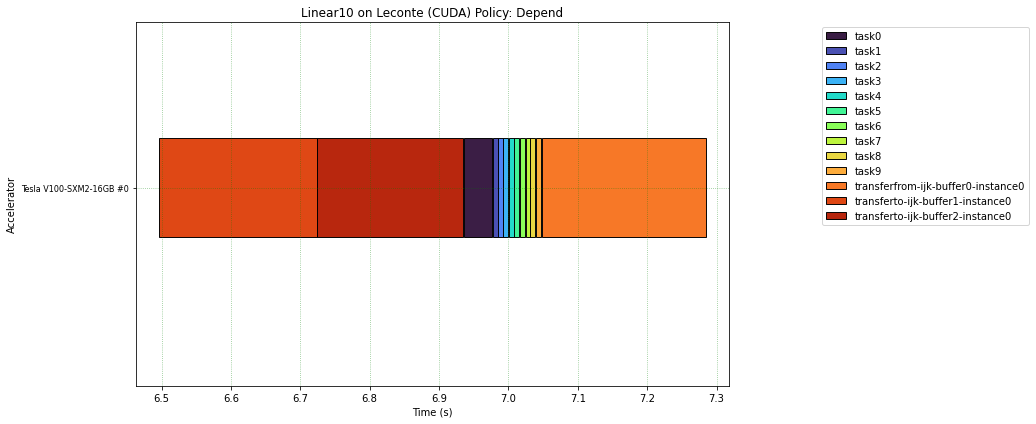

In [265]:
# no results omitted
#! cat ./dagger-results/dagger_runner-Leconte-depend.csv > filtered.csv
#without init
! cat ./dagger-results/dagger_runner-Leconte-depend.csv | grep -vE 'Init' > filtered.csv
# without all
#! cat ./dagger-results/dagger_runner-Leconte-depend.csv | grep -vE 'Init' | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.showGanttChart(fp.pop(),"Linear10 on Leconte (CUDA) Policy: Depend",zoom=True)
#g.showGanttChart(fp.pop(),"Linear10 on Equinox (CUDA)",time_range=(0.624,0.632))

Without Initialization:

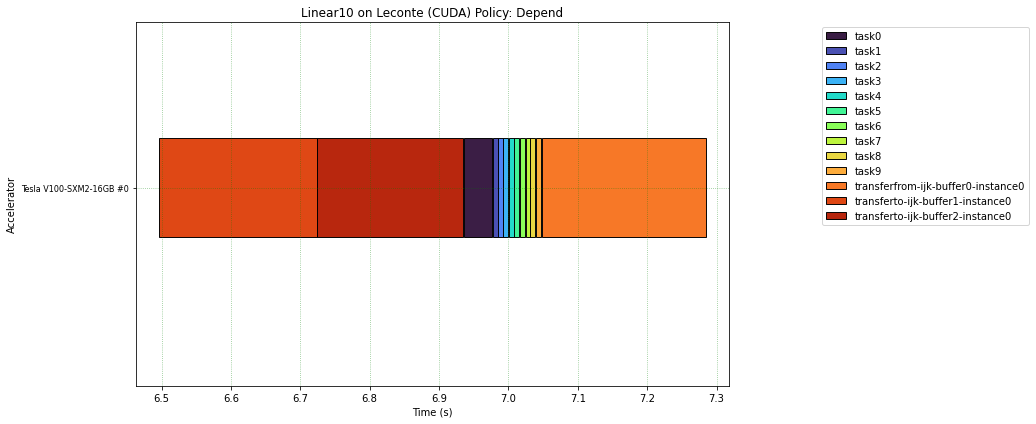

In [9]:
# and without the Init times
! cat ./dagger-results/dagger_runner-Leconte-depend.csv | grep -vE 'Init' > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.saveGanttChart(fp.pop(),file="rawish-linear10-depend-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Depend",zoom=True)

#g.showGanttChart(fp.pop(),"Linear10 on Equinox (CUDA)",time_range=(0.624,0.632))

### Profile (without Initialization) on Leconte

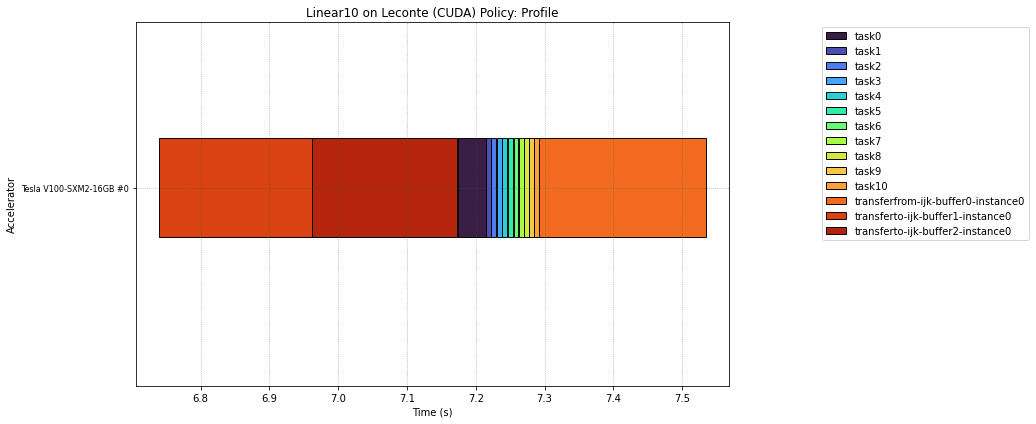

In [218]:
! cat ./dagger-results/dagger_runner-Leconte-profile.csv | grep -vE 'Init' > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.showGanttChart(fp.pop(),"Linear10 on Leconte (CUDA) Policy: Profile",zoom=True)
#g.showGanttChart(fp.pop(),"Linear10 on Equinox (CUDA)",time_range=(0.624,0.632))

### Random (without Initialization) on Leconte

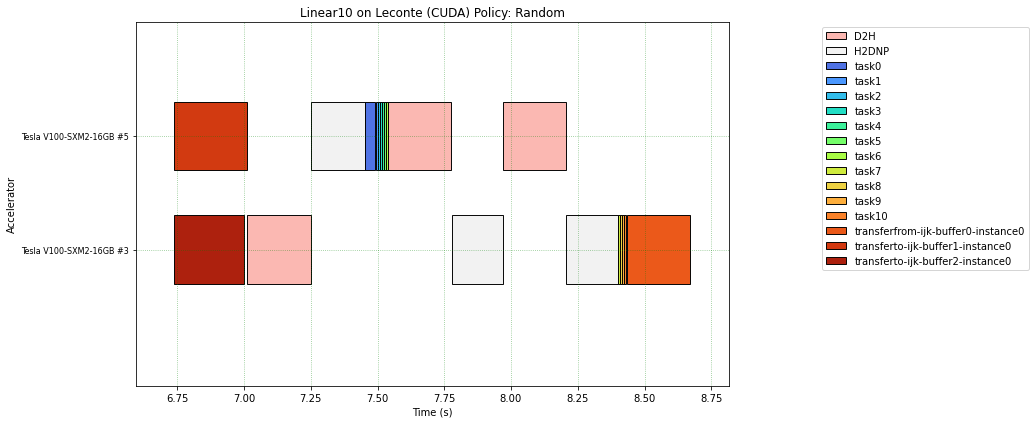

In [219]:
! cat ./dagger-results/dagger_runner-Leconte-random.csv | grep -vE 'Init' > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.showGanttChart(fp.pop(),"Linear10 on Leconte (CUDA) Policy: Random",zoom=True)

### Any (without Initialization) on Leconte

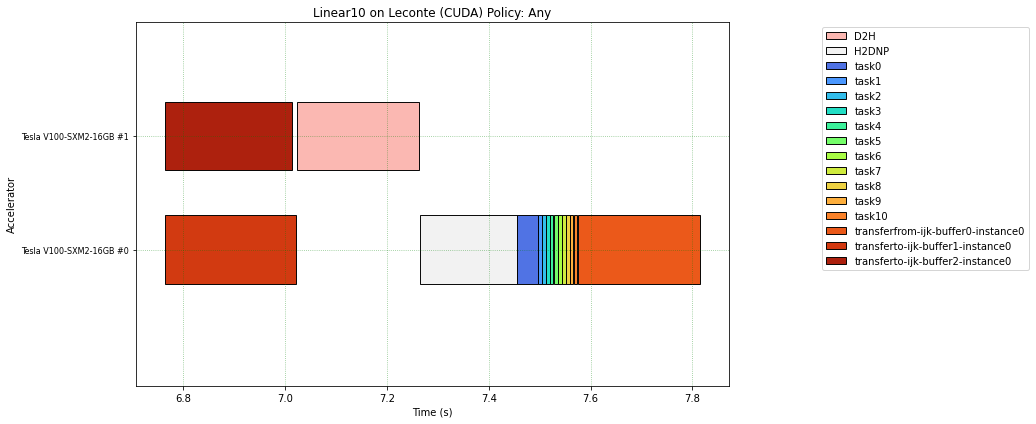

In [220]:
! cat ./dagger-results/dagger_runner-Leconte-any.csv | grep -vE 'Init' > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.showGanttChart(fp.pop(),"Linear10 on Leconte (CUDA) Policy: Any",zoom=True)

### All (without Initialization) on Leconte

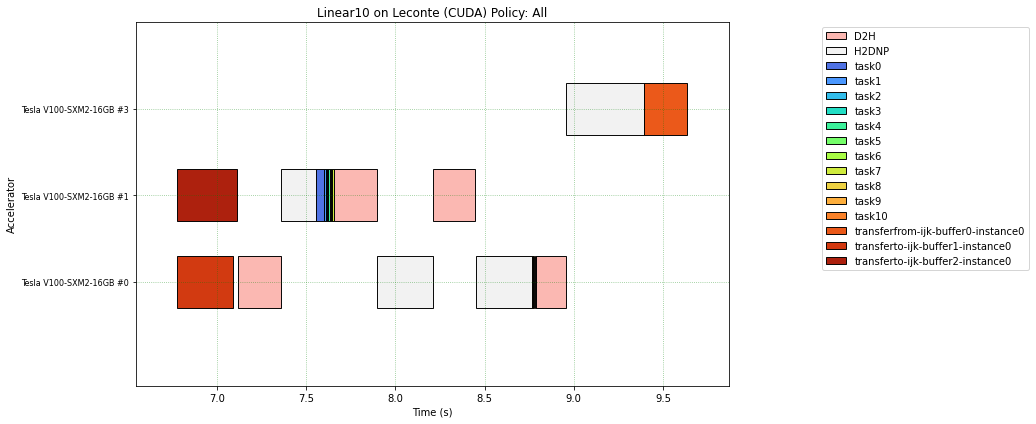

In [221]:
! cat ./dagger-results/dagger_runner-Leconte-all.csv | grep -vE 'Init' > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.showGanttChart(fp.pop(),"Linear10 on Leconte (CUDA) Policy: All",zoom=True)

### Data Policy


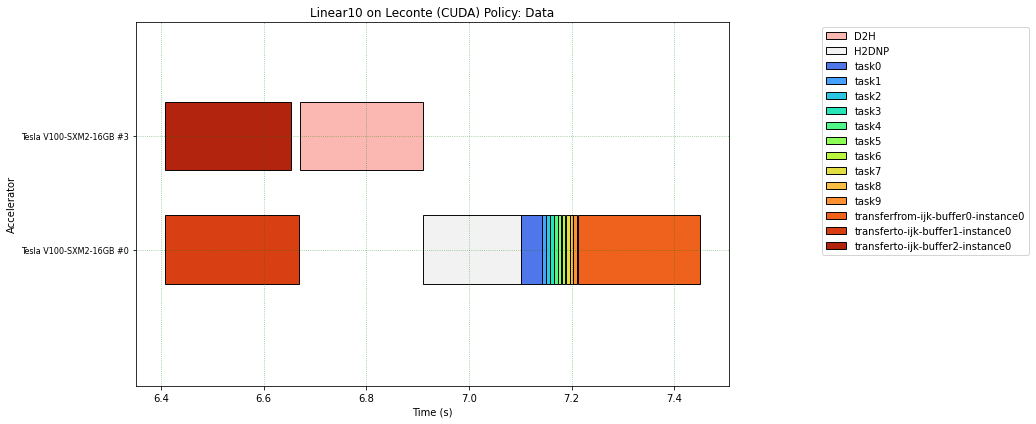

In [267]:
# no results omitted
#! cat ./dagger-results/dagger_runner-Leconte-data.csv > filtered.csv
#without init
! cat ./dagger-results/dagger_runner-Leconte-data.csv | grep -vE 'Init' > filtered.csv
# without all
#! cat ./dagger-results/dagger_runner-Leconte-data.csv | grep -vE 'Init' | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.showGanttChart(fp.pop(),"Linear10 on Leconte (CUDA) Policy: Data",zoom=True)
#g.showGanttChart(fp.pop(),"Linear10 on Equinox (CUDA)",time_range=(0.624,0.632))

## Equinox

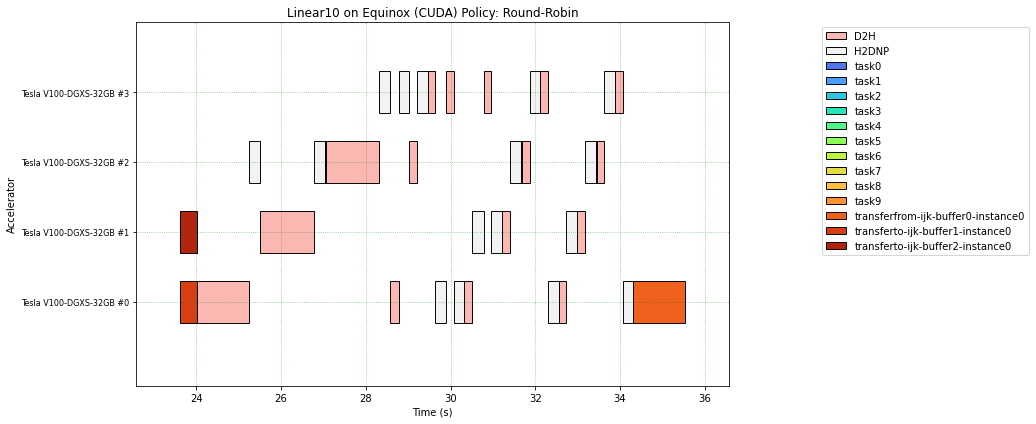

In [7]:
#no initialization reported:
! cat ./dagger-results/dagger_runner-Equinox-roundrobin.csv | grep -vE 'Init' > filtered.csv
#no H2D or D2H reported:
#! cat ./dagger-results/dagger_runner-Equinox-roundrobin.csv | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#no filtering:
#! cat ./dagger-results/dagger_runner-Equinox-roundrobin.csv > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
#g.showGanttChart(fp.pop(),"Linear10 on Equinox (CUDA) Policy: Round-Robin",zoom=True)
g.saveGanttChart(fp.pop(),file="",title="Linear10 on Equinox (CUDA) Policy: Round-Robin",zoom=True)


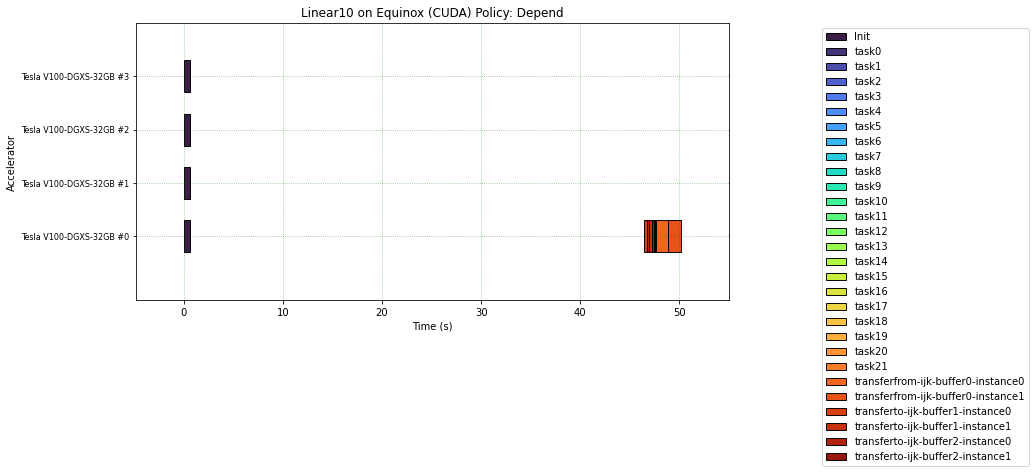

In [232]:
#no initialization reported:
#! cat ./dagger-results/dagger_runner-Equinox-depend.csv | grep -vE 'Init' > filtered.csv
#no H2D or D2H reported:
#! cat ./dagger-results/dagger_runner-Equinox-depend.csv | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#no filtering:
! cat ./dagger-results/dagger_runner-Equinox-depend.csv > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.showGanttChart(fp.pop(),"Linear10 on Equinox (CUDA) Policy: Depend",zoom=True)

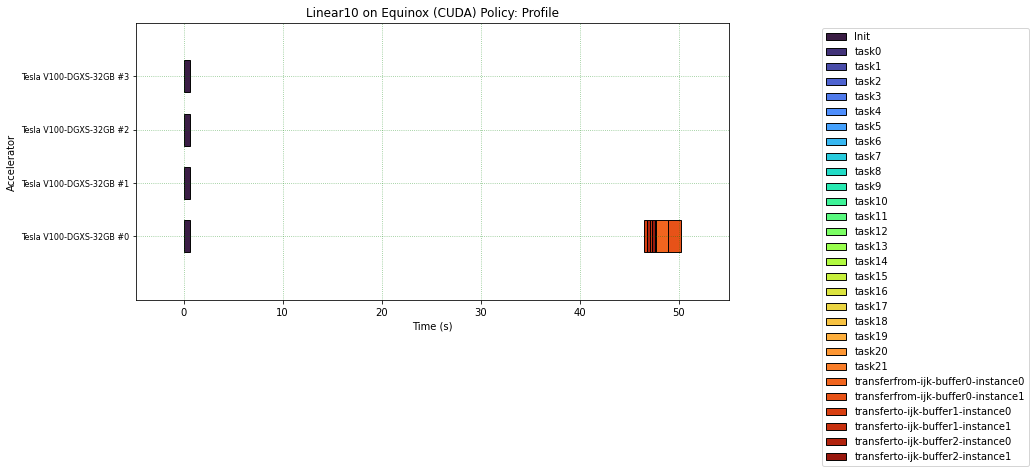

In [233]:
#no initialization reported:
#! cat ./dagger-results/dagger_runner-Equinox-profile.csv | grep -vE 'Init' > filtered.csv
#no H2D or D2H reported:
#! cat ./dagger-results/dagger_runner-Equinox-profile.csv | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#no filtering:
! cat ./dagger-results/dagger_runner-Equinox-profile.csv > filtered.csv

g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.showGanttChart(fp.pop(),"Linear10 on Equinox (CUDA) Policy: Profile",zoom=True)

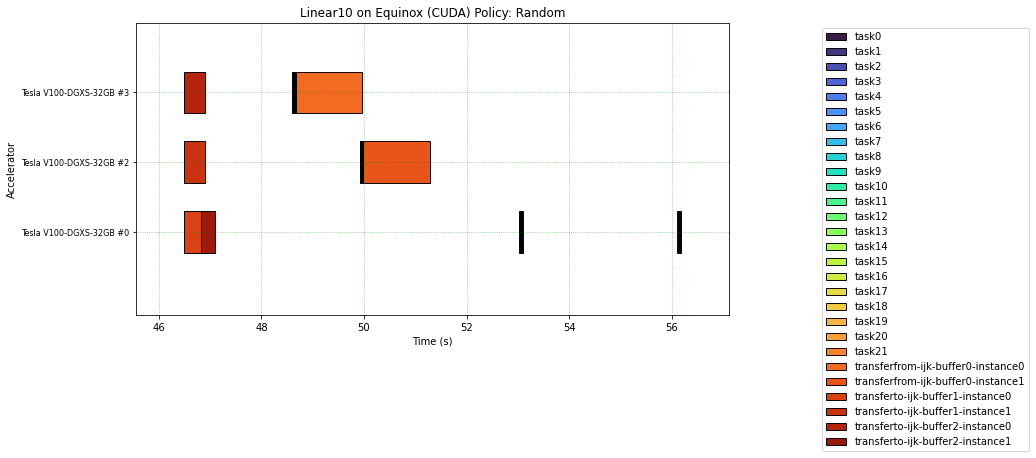

In [236]:
#no initialization reported:
#! cat ./dagger-results/dagger_runner-Equinox-random.csv | grep -vE 'Init' > filtered.csv
#no H2D or D2H reported:
#! cat ./dagger-results/dagger_runner-Equinox-random.csv | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#fully filtered:
! cat ./dagger-results/dagger_runner-Equinox-random.csv | grep -vE 'Init' | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#no filtering:
#! cat ./dagger-results/dagger_runner-Equinox-random.csv > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.showGanttChart(fp.pop(),"Linear10 on Equinox (CUDA) Policy: Random",zoom=True)

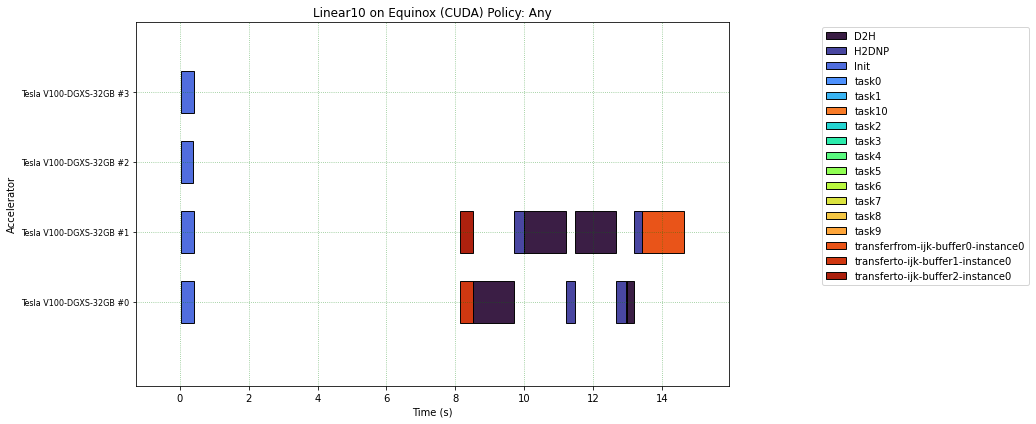

In [167]:
#no initialization reported:
#! cat ./dagger-results/dagger_runner-Equinox-any.csv | grep -vE 'Init' > filtered.csv
#no H2D or D2H reported:
#! cat ./dagger-results/dagger_runner-Equinox-any.csv | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#no filtering:
! cat ./dagger-results/dagger_runner-Equinox-any.csv > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.showGanttChart(fp.pop(),"Linear10 on Equinox (CUDA) Policy: Any",zoom=True)

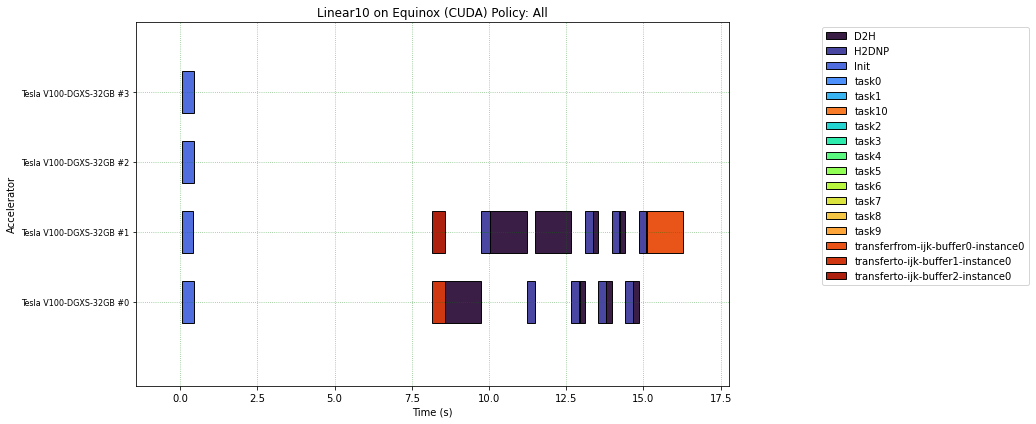

In [168]:
#no initialization reported:
#! cat ./dagger-results/dagger_runner-Equinox-all.csv | grep -vE 'Init' > filtered.csv
#no H2D or D2H reported:
#! cat ./dagger-results/dagger_runner-Equinox-all.csv | grep -vE 'H2DNP' | grep -vE 'D2H'  > filtered.csv
#no filtering:
! cat ./dagger-results/dagger_runner-Equinox-all.csv > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.showGanttChart(fp.pop(),"Linear10 on Equinox (CUDA) Policy: All",zoom=True)

# Scatter-Gather Type DAG


```
(iris) ➜  dagger git:(logging) ✗ ./dagger_generator.py --kernels="ijk" --kernel-split='100' --depth=1 --num-tasks=1 --min-width=1 --max-width=10 --concurrent-kernels="ijk:3" --buffers-per-kernel="ijk:w r r" --kernel-dimensions="ijk:2"                                                                                              
````
On Leconte:
```
➜  dagger git:(logging) ✗ ./dagger_runner --logfile="test.csv" --repeats=1 --scheduling-policy="data" --size=1024 --kernels="ijk" --kernel-split='100' --depth=1 --num-tasks=3 --min-width=3 --max-width=3 --concurrent-kernels="ijk:3" --buffers-per-kernel="ijk:w r r" --kernel-dimensions="ijk:2"  
```

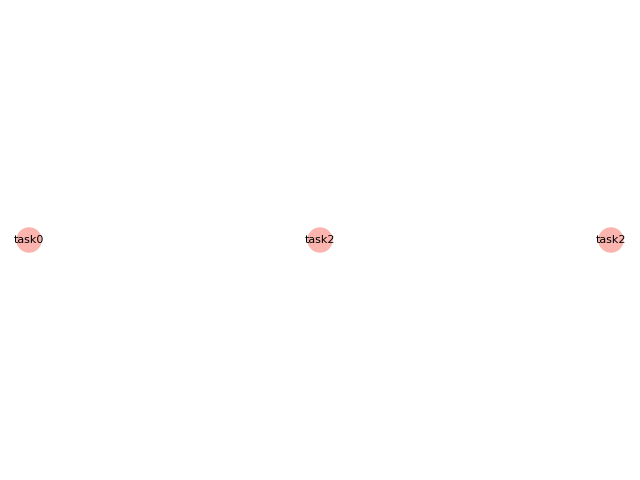

In [31]:
from IPython.display import Image
Image("./dag.png", width=600, height=600)

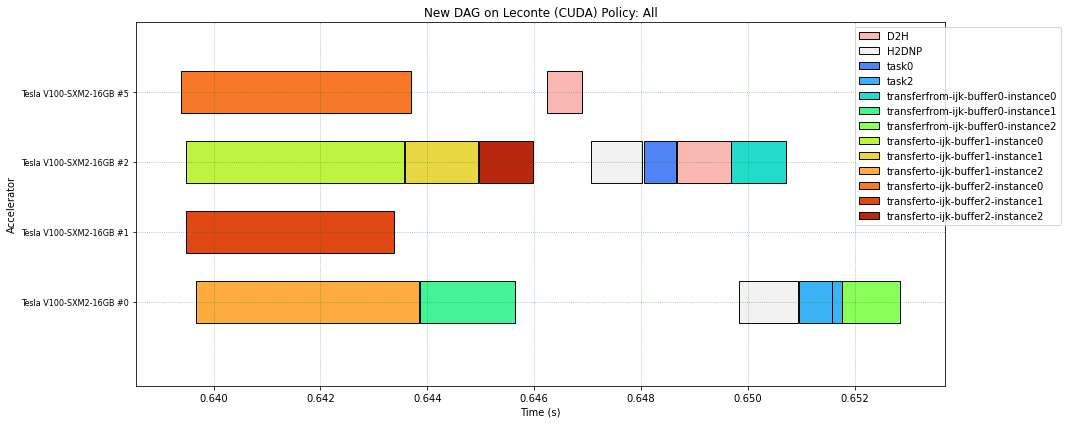

In [34]:
! cat ./dagger_runner-leconte-20220120-203453.csv | grep -vE 'Init'  > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.showGanttChart(fp.pop(),"New DAG on Leconte (CUDA) Policy: All",zoom=True)


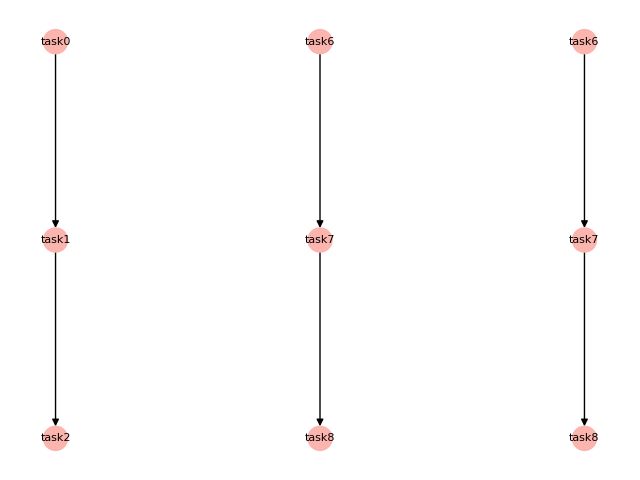

In [42]:
from IPython.display import Image
Image("./dag.png", width=600, height=600)

# Interesting Shapes

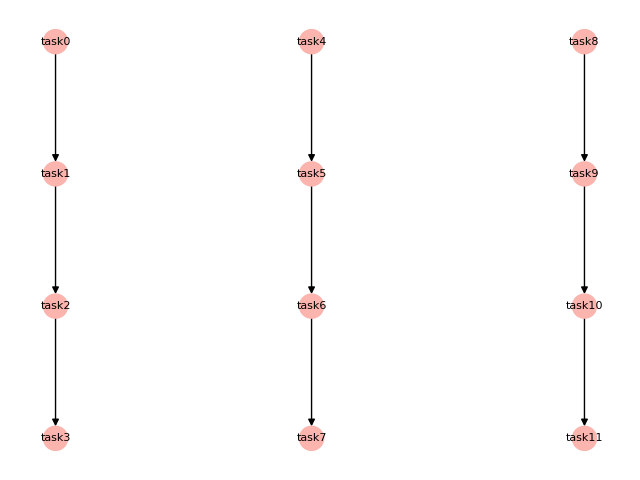

In [69]:

from IPython.display import Image
Image("./dag.png", width=600, height=600)

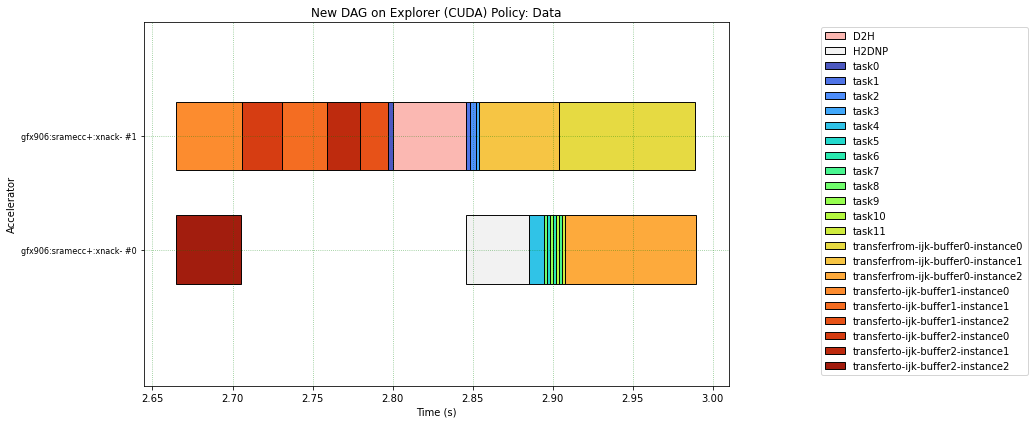

In [70]:
! cat ./dagger_runner-explorer-*.csv | grep -vE 'Init'  > filtered.csv

from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('./filtered.csv')
g.showGanttChart(fp.pop(),"New DAG on Explorer (CUDA) Policy: Data",zoom=True)


# Linear 10x3 Benchmark

## Generate with DAGGER and view

**Note:** The `ijk` kernel is the name of the major compute component for DGEMM.

TODO: ensure all kernels dimensions are provided---no kernel is missed
TODO: Implement kernel_dimensions
TODO: could handle multiple dimensions of execution here
TODO: support multiple targets--hint all but the h2d and d2h memory transfers should be transfer target (control-dependency) while all actual kernels should use the data-dependency
done


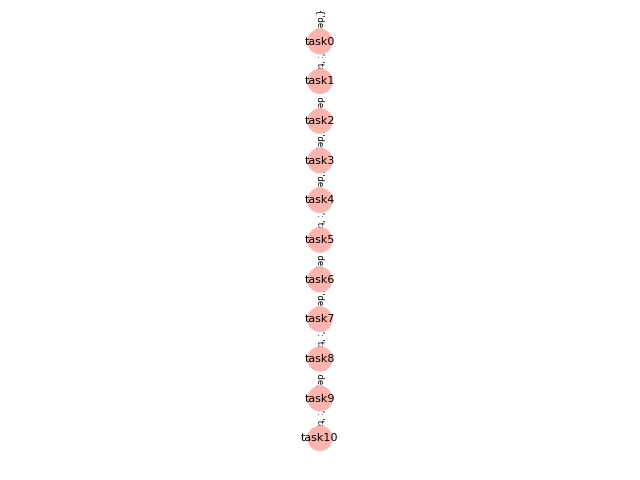

In [143]:
! ./dagger_generator.py --kernels="ijk" --kernel-split='100' --depth=10 --num-tasks=9 --min-width=1 --max-width=1 --concurrent-kernels="ijk:3" --buffers-per-kernel="ijk:w r r" --kernel-dimensions="ijk:2"

from IPython.display import Image
Image("./dag.png", width=600, height=600)

# Concurrent 100 Benchmark

# Relative Performance

**TODO:** plot this by grouping different lines by type (solid for base-line, dashed for round-robin, dotted for greedy, etc)

### Misc Debugging

In [7]:
#the following can be used to reload the gantt package in python while we rewrite/modify the library.
%config Completer.use_jedi = False

#The following reload is for iterative development
from importlib import reload 

from gantt import gantt as gantt
reload(gantt)

<module 'gantt.gantt' from '/home/9bj/Documents/2022/iris-private/apps/dagger/gantt/gantt.py'>

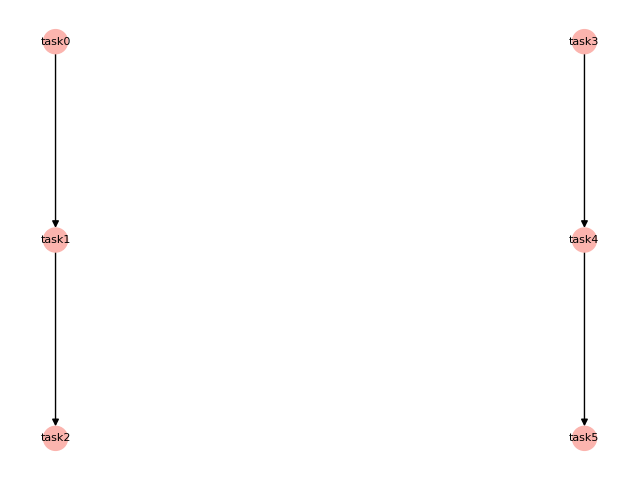

In [23]:
Image("./dag.png", width=600, height=600)

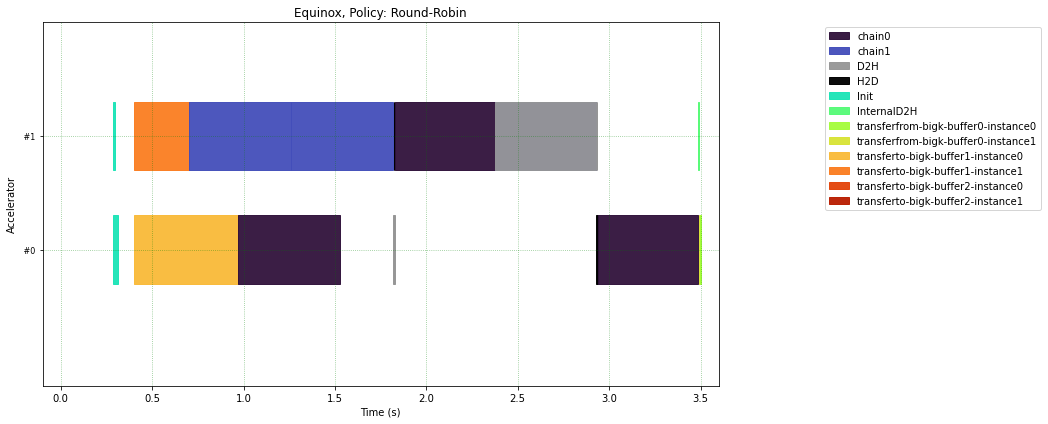

In [18]:
from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = ['evaluation.csv']
#fp = glob('dagger_runner-explorer-*.csv')
g.showGanttChart(fp.pop(),title="Equinox, Policy: Round-Robin", drop=[], outline=False)
#g.saveGanttChart(glob('./filtered.csv').pop(),file="filtered-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")


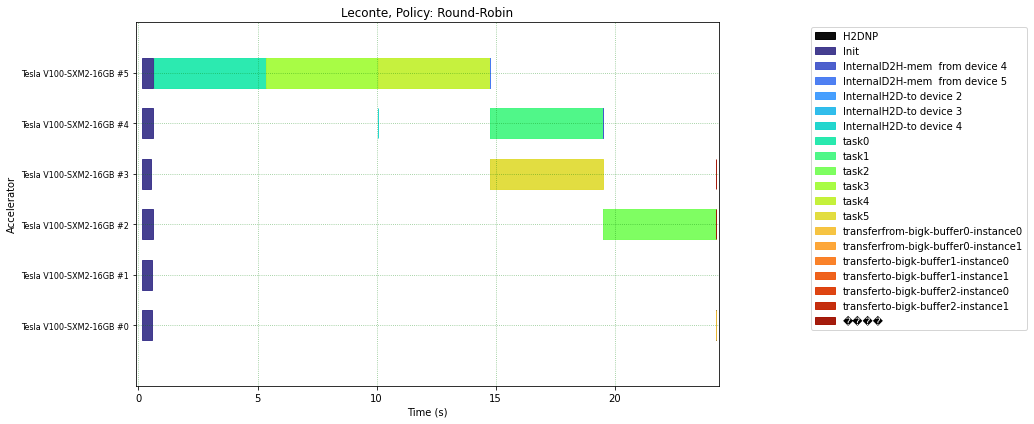

In [25]:
from gantt import gantt as gantt
g = gantt.Gantt()
from glob import glob
fp = glob('dagger_runner-*.csv')
#fp = glob('dagger_runner-explorer-*.csv')
g.showGanttChart(fp.pop(),title="Leconte, Policy: Round-Robin", drop=[], outline=False)
#g.saveGanttChart(glob('./filtered.csv').pop(),file="filtered-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")


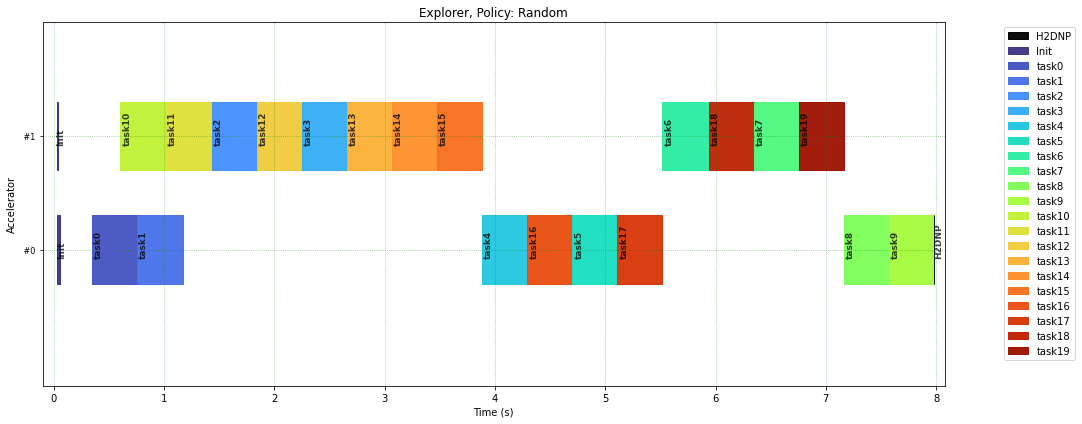

In [72]:
import importlib
from gantt import gantt as gantt
importlib.reload(gantt)
g = gantt.Gantt()
from glob import glob
fp = glob('dagger_runner-*.csv')
#fp = glob('dagger_runner-explorer-*.csv')
dropsies = ["transferfrom-bigk-buffer0-instance0",
            "transferfrom-bigk-buffer0-instance1",
            "transferto-bigk-buffer1-instance0",
            "transferto-bigk-buffer1-instance1",
            "transferto-bigk-buffer2-instance0",
            "transferto-bigk-buffer2-instance1",
            "Internal-D2H", "Internal-H2D"]
g.showGanttChart(fp.pop(),title="Explorer, Policy: Random", drop=dropsies, outline=False, inner_label=True)
#g.saveGanttChart(glob('./filtered.csv').pop(),file="filtered-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")


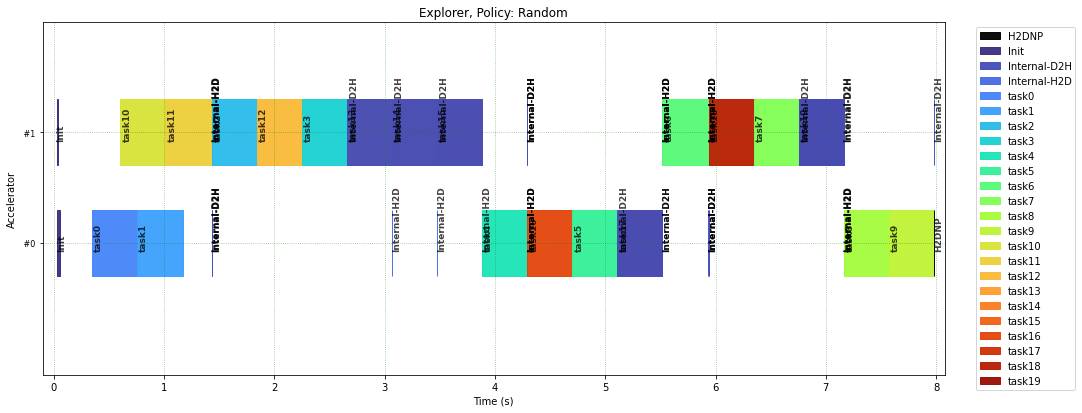

In [73]:
import importlib
from gantt import gantt as gantt
importlib.reload(gantt)
g = gantt.Gantt()
from glob import glob
fp = glob('dagger_runner-*.csv')
#fp = glob('dagger_runner-explorer-*.csv')
dropsies = ["transferfrom-bigk-buffer0-instance0",
            "transferfrom-bigk-buffer0-instance1",
            "transferto-bigk-buffer1-instance0",
            "transferto-bigk-buffer1-instance1",
            "transferto-bigk-buffer2-instance0",
            "transferto-bigk-buffer2-instance1"]
g.showGanttChart(fp.pop(),title="Explorer, Policy: Random", drop=dropsies, outline=False, inner_label=True)
#g.saveGanttChart(glob('./filtered.csv').pop(),file="filtered-linear10-round-robin-leconte.pdf",title="Linear10 on Leconte (CUDA) Policy: Round-Robin")


# Diamond 10

TODO: ensure all kernels dimensions are provided---no kernel is missed
TODO: Implement kernel_dimensions
TODO: could handle multiple dimensions of execution here
TODO: support multiple targets--hint all but the h2d and d2h memory transfers should be transfer target (control-dependency) while all actual kernels should use the data-dependency
done


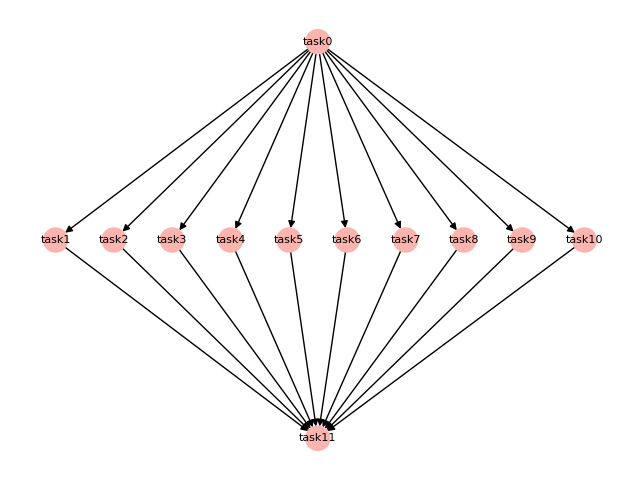

In [76]:
! ./dagger_generator.py --kernels="bigk" --kernel-split='100' --depth=1 --num-tasks=10 --min-width=10 --max-width=10 --concurrent-kernels="bigk:3" --buffers-per-kernel="bigk:w r r" --kernel-dimensions="bigk:2" --sandwich
! mv dag.png ./iris-and-dagger-paper/figures/Diamond10.png
from IPython.display import Image
Image("./iris-and-dagger-paper/figures/Diamond10.png", width=600, height=600)

# Parallel 5by100

TODO: ensure all kernels dimensions are provided---no kernel is missed
TODO: Implement kernel_dimensions
TODO: still need to support concurrent kernels...
TODO: could handle multiple dimensions of execution here
TODO: support multiple targets--hint all but the h2d and d2h memory transfers should be transfer target (control-dependency) while all actual kernels should use the data-dependency
done


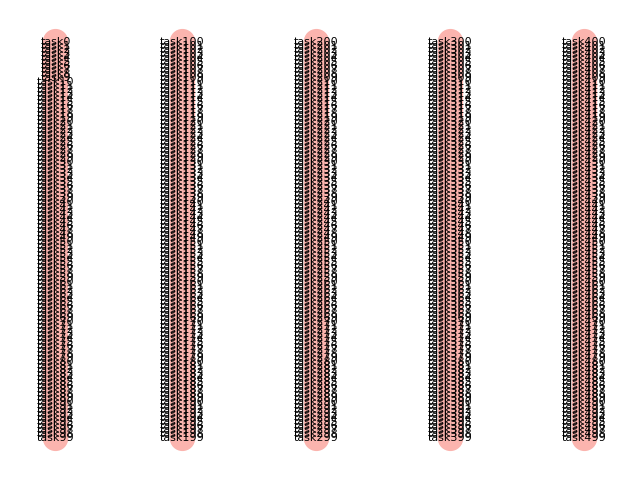

In [77]:
! ./dagger_generator.py --kernels="bigk" --duplicates="5" --buffers-per-kernel="bigk:w r r" --kernel-dimensions="bigk:2" --kernel-split='100' --depth=100 --num-tasks=100 --min-width=1 --max-width=1
from IPython.display import Image
Image("dag.png", width=600, height=600)

# Diamond 1000

TODO: ensure all kernels dimensions are provided---no kernel is missed
TODO: Implement kernel_dimensions
TODO: could handle multiple dimensions of execution here
TODO: support multiple targets--hint all but the h2d and d2h memory transfers should be transfer target (control-dependency) while all actual kernels should use the data-dependency
done


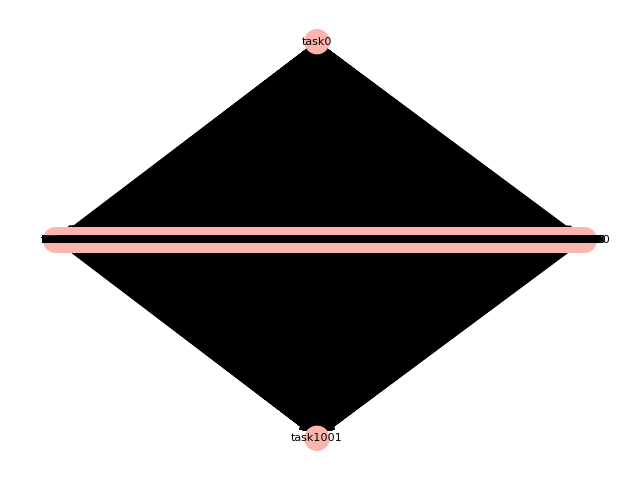

In [78]:
! ./dagger_generator.py --kernels="bigk" --kernel-split='100' --depth=1 --num-tasks=1000 --min-width=1000 --max-width=1000 --concurrent-kernels="bigk:3" --buffers-per-kernel="bigk:w r r" --kernel-dimensions="bigk:2" --sandwich
from IPython.display import Image
Image("dag.png", width=600, height=600)

# Chainlink 25

TODO: ensure all kernels dimensions are provided---no kernel is missed
TODO: Implement kernel_dimensions
TODO: could handle multiple dimensions of execution here
TODO: support multiple targets--hint all but the h2d and d2h memory transfers should be transfer target (control-dependency) while all actual kernels should use the data-dependency
done


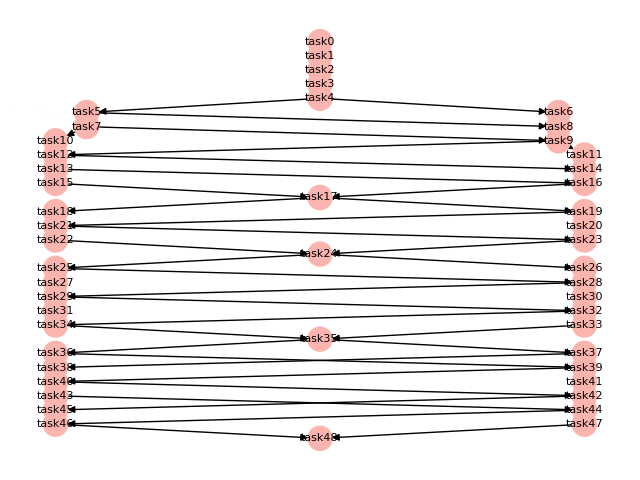

In [91]:
! ./dagger_generator.py --kernels="bigk" --kernel-split='100' --depth=25 --num-tasks=50 --min-width=1 --max-width=2 --concurrent-kernels="bigk:3" --buffers-per-kernel="bigk:w r r" --kernel-dimensions="bigk:2" --sandwich --cdf-mean=2 --cdf-std-dev=0
from IPython.display import Image
Image("dag.png", width=600, height=600)

# Galaga 25

TODO: ensure all kernels dimensions are provided---no kernel is missed
TODO: Implement kernel_dimensions
TODO: could handle multiple dimensions of execution here
TODO: support multiple targets--hint all but the h2d and d2h memory transfers should be transfer target (control-dependency) while all actual kernels should use the data-dependency
done


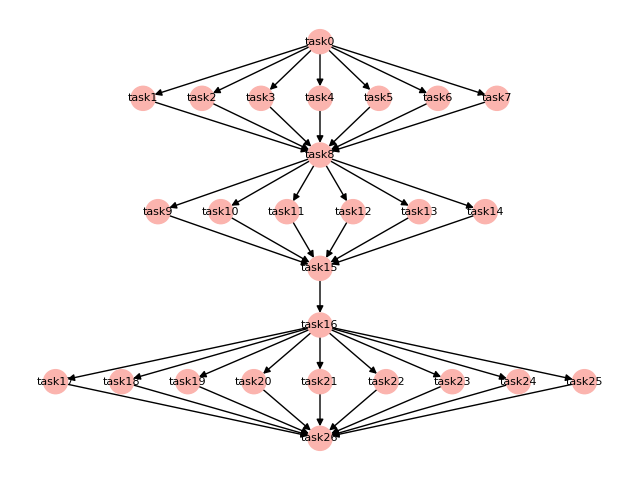

In [97]:
! ./dagger_generator.py --kernels="bigk" --kernel-split='100' --depth=25 --num-tasks=25 --min-width=1 --max-width=12 --concurrent-kernels="bigk:3" --buffers-per-kernel="bigk:w r r" --kernel-dimensions="bigk:2" --sandwich --cdf-mean=2 --cdf-std-dev=0
from IPython.display import Image
Image("dag.png", width=600, height=600)


# Tangled 25

TODO: ensure all kernels dimensions are provided---no kernel is missed
TODO: Implement kernel_dimensions
TODO: could handle multiple dimensions of execution here
TODO: support multiple targets--hint all but the h2d and d2h memory transfers should be transfer target (control-dependency) while all actual kernels should use the data-dependency
done


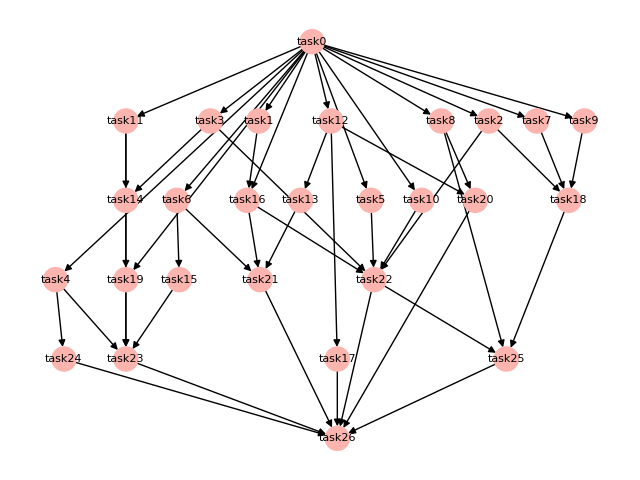

In [98]:
! ./dagger_generator.py --kernels="bigk" --kernel-split='100' --depth=25 --num-tasks=25 --min-width=1 --max-width=12 --concurrent-kernels="bigk:3" --buffers-per-kernel="bigk:w r r" --kernel-dimensions="bigk:2" --sandwich --cdf-mean=2 --cdf-std-dev=0 --skips=3
from IPython.display import Image
Image("dag.png", width=600, height=600)


# Brain 1000

TODO: ensure all kernels dimensions are provided---no kernel is missed
TODO: Implement kernel_dimensions
TODO: could handle multiple dimensions of execution here
TODO: support multiple targets--hint all but the h2d and d2h memory transfers should be transfer target (control-dependency) while all actual kernels should use the data-dependency
done


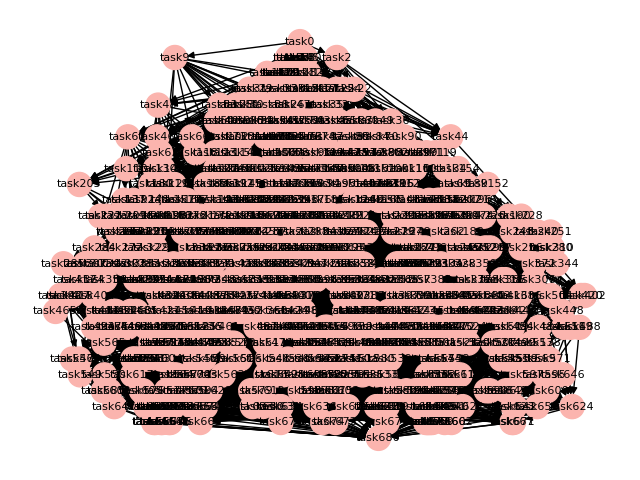

In [106]:
! ./dagger_generator.py --kernels="bigk" --kernel-split='100' --depth=25 --num-tasks=1000 --min-width=1 --max-width=50 --concurrent-kernels="bigk:3" --buffers-per-kernel="bigk:w r r" --kernel-dimensions="bigk:2" --sandwich --cdf-mean=10 --cdf-std-dev=5 --skips=10
from IPython.display import Image
Image("dag.png", width=600, height=600)
